In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from datetime import datetime
np.warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras import Model, layers, Sequential
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import CSVLogger
#from tensorflow.keras.preprocessing import timeseries_dataset_from_array
#Create a Baseline --> a linear function
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.listdir('/quanta1/home/sang/GR/ML0D/jupyter/')
#os.listdir('/scratch/seismology/sang/EqSimuData')

['rsf0.ipynb',
 'submit_train.sbatch',
 'checkpoints',
 'train.py',
 'cutsample.sh',
 'figs',
 'rsf0_trainset.csv',
 '__pycache__',
 'rupture_process.ipynb',
 '.ipynb_checkpoints',
 'checkpoint',
 'model_df.py',
 'rsf0_regimes.ipynb',
 'data_window.py']

In [2]:
#test_df=pd.read_csv('/quanta1/home/sang/GR/ML0D/rsf0_test.csv')
total_df=pd.read_csv('/quanta1/home/sang/GR/ML0D/jupyter/rsf0_trainset.csv')
total_df.shape

(50000000, 10)

In [3]:
#Too big --> split into three parts
Nt=5000
n=2000
total_df1=total_df[0:Nt*n]
df=total_df1
df.shape

(10000000, 10)

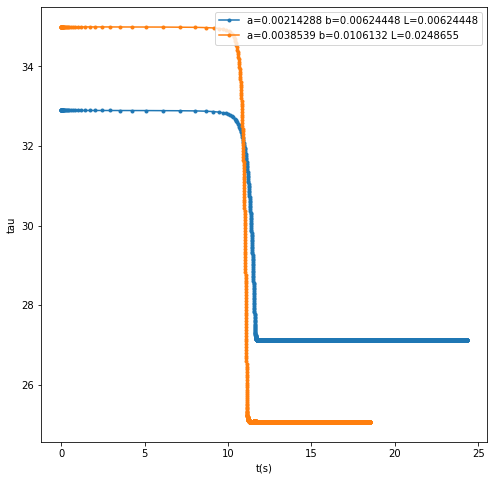

In [99]:
df_group1=total_df[total_df['group_id']==1]
df_group455=total_df[total_df['group_id']==455]
plt.figure(figsize=(8,8))
plt.ylabel('tau')
plt.xlabel('t(s)')
plt.plot(df_group1.t, df_group1.tau, marker='.',label=f'a={df_group1.a.unique()[0]} b={df_group1.b.unique()[0]} L={df_group1.b.unique()[0]}')
plt.plot(df_group455.t, df_group455.tau, marker='.', label=f'a={df_group455.a.unique()[0]} b={df_group455.b.unique()[0]} L={df_group455.L.unique()[0]}')
plt.legend()
plt.savefig(fname='figs/general_groups.png')

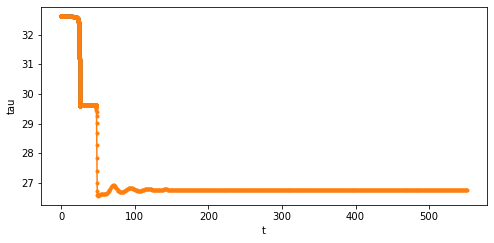

In [6]:
#Some unreal data
#idx=df.loc[(df['V']<=0.0), 'group_id'].unique()
#print(idx)  #No 'V'<=0
#idx=df.loc[(df['t']>=500), 'group_id'].unique()
#print(idx)  #[  125   131   134 ... 30057 30060 30061] len(idx)=1563
df_group125=df[df['group_id']==125]
#print(df_group125.shape)  #Nt=5000
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.ylabel('tau')
plt.xlabel('t')
plt.plot(df_group125.t[0:800], df_group125.tau[0:800], marker='.')
plt.plot(df_group125.t, df_group125.tau, marker='.')
#Double fork V

In [83]:
class Datasample():
    def __init__(self, df):
        self.df=df
    def add_features(self, Nt):
        #Eiliminate unreal data
        id_idx=self.df.loc[(self.df['V']<=0.0), 'group_id'].unique()
        self.df=self.df[~self.df['group_id'].isin(id_idx)]
        
        self.df['tau_lag']=self.df.groupby(self.df['group_id'])['tau'].shift(1)
        self.df['V_lag']=self.df.groupby(self.df['group_id'])['V'].shift(1)
        self.df['dtau']=self.df['tau_lag']-self.df['tau']
        self.df['dV']=self.df['V_lag']-self.df['V']
        self.df['dtau/dt']=self.df['dtau']/self.df['dt']
        self.df=self.df.fillna(0)
        
        start_datetime=datetime.now()
        groups=len(self.df.group_id.unique())
        df_new=pd.DataFrame()
        for i in range(groups):
            df_group=self.df.iloc[Nt*i : Nt*(i+1)]
            
            start_t=df_group[df_group['dtau/dt'] >=1].iloc[0,4]
            stop_t=df_group[df_group['dtau/dt']>=1].iloc[-1,4]
            df_group=df_group.loc[df_group[df_group.t == start_t].index.tolist()[0] :
                                  df_group[df_group.t == stop_t].index.tolist()[0]]
            #Eliminate double fork V
            if (df_group.iloc[10,-2]*df_group.iloc[11,-2]) <=0\
            or (df_group.iloc[33,-2]*df_group.iloc[34,-2]) <=0\
            or (df_group.iloc[54,-2]*df_group.iloc[55,-2]) <=0:
                continue
            
            df_group=df_group[['group_id','a','b','L','t','theta','U','V','tau']]
            #Resample
            df_group['t']=pd.to_timedelta(df_group['t'], unit='s')
            df_group.set_index('t', inplace=True)
            df_group=df_group.resample('1ms').mean().interpolate('linear').reset_index(drop=False)
            #df_group=df_group.resample('5ms').mean().interpolate('linear').reset_index(drop=False)
            #df_group=df_group.resample('10ms').mean().interpolate('linear').reset_index(drop=False)
            df_group.t=df_group['t'].dt.total_seconds()
            
            #New features
            df_group['dtau']=df_group['tau'].shift(1)-df_group['tau']
            df_group['dtau2']=df_group['tau'].shift(2)-df_group['tau']
            df_group['dV']=df_group['V'].shift(1)-df_group['V']
            df_group['dV2']=df_group['V'].shift(1)-df_group['V']
            df_group['dU']=df_group['U'].shift(1)-df_group['U']
            df_group['dU2']=df_group['U'].shift(2)-df_group['U']
            df_group['dtheta']=df_group['theta'].shift(1)-df_group['theta']
            df_group['dtheta2']=df_group['theta'].shift(2)-df_group['theta']
            df_group=df_group.fillna(0)
            
            #Eliminate too much time to rupture
            if df_group.shape[0]>10000:
                continue
            df_new=df_new.append(df_group)
        self.df=df_new[['group_id','a','b','L','dtau','dtau2','theta','dtheta','dtheta2','U','dU','dU2','V',
                        'dV','dV2','tau']]
        N=self.df.groupby('group_id').size().tolist()
        print(datetime.now()-start_datetime)
        return self.df, N
    
    def split_df(self, N):
        #Split the data_df into train:val:test=7:2:1 with 'group_id's
        #And not shuffle when spliting df --> make series dataset
        num_columns=self.df.shape[-1]
        column_indices={name: i for i, name in enumerate(self.df.columns)}
        
        N_new=np.zeros(len(N), dtype=int)
        for i in range(len(N)):
            if i==0:
                N_new[i]=N[i]
            else:
                N_new[i]=N[i]+N_new[i-1]
        N[:]=N_new[:]
        
        test_groups=int(len(N)*1/10)
        val_groups=int(len(N)*2/10)
        train_groups=len(N)-test_groups-val_groups
        train_num=train_groups-1
        val_num=train_groups+val_groups-1
        
        train_df=self.df.iloc[0:N[train_num], :]
        val_df=self.df.iloc[N[train_num]:N[val_num], :]
        test_df=self.df.iloc[N[val_num]:, :]
        return train_df, val_df, test_df, N
    
    def normalization(self, train_df, val_df, test_df):
        train_mean=train_df.mean()
        train_std=train_df.std()
        if abs(train_std['a'])<1e-10:
            train_std['a']=1.0
        if abs(train_std['b'])<1e-10:
            train_std['b']=1.0
        if abs(train_std['L'])<1e-10:
            train_std['L']=1.0
        
        train_df_nor=(train_df - train_mean) / train_std
        val_df_nor=(val_df - train_mean) / train_std
        test_df_nor=(test_df - train_mean) / train_std
        return train_df_nor, val_df_nor, test_df_nor, train_mean, train_std

In [8]:
#10ms
df,N=Datasample(total_df1).add_features(Nt)
print(df.shape)
num_columns=df.shape[-1]
column_indices={name: i for i, name in enumerate(df.columns)}
print(num_columns)
print(column_indices)

train_df, val_df, test_df, N_new=Datasample(df).split_df(N)
print(f'train_df.shape={train_df.shape}')
print(f'val_df.shape={val_df.shape}')
print(f'test_df.shape={test_df.shape}')
train_groups=train_df.group_id.unique()
val_groups=val_df.group_id.unique()
test_groups=test_df.group_id.unique()
print(len(train_groups))
print(len(val_groups))
print(len(test_groups))

train_df_nor, val_df_nor, test_df_nor, train_mean, train_std=Datasample(df).normalization(train_df, val_df, test_df)
print(f'train_df_nor.shape = {train_df_nor.shape}')
print(f'val_df_nor.shape = {val_df_nor.shape}')
print(f'test_df_nor.shape = {test_df_nor.shape}')
print(f'train_mean = {train_mean}')
print(f'train_std = {train_std}')

0:00:22.853887
(135375, 16)
16
{'group_id': 0, 'a': 1, 'b': 2, 'L': 3, 'dtau': 4, 'dtau2': 5, 'theta': 6, 'dtheta': 7, 'dtheta2': 8, 'U': 9, 'dU': 10, 'dU2': 11, 'V': 12, 'dV': 13, 'dV2': 14, 'tau': 15}
train_df.shape=(92315, 16)
val_df.shape=(25589, 16)
test_df.shape=(17471, 16)
1222
349
174
train_df_nor.shape = (92315, 16)
val_df_nor.shape = (25589, 16)
test_df_nor.shape = (17471, 16)
train_mean = group_id       682.273791
a                0.005722
b                0.012527
L                0.024866
dtau             0.153578
dtau2            0.306804
theta       610981.516342
dtheta       40754.457814
dtheta2      79992.857479
U                0.245746
dU              -0.008850
dU2             -0.017431
V                0.901578
dV              -0.031647
dV2             -0.031647
tau             32.087640
dtype: float64
train_std = group_id    3.921208e+02
a           2.670062e-03
b           4.380138e-03
L           1.000000e+00
dtau        2.410343e-01
dtau2       4.781189e-01
thet

In [9]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df, label_columns=None):
        self.train_df=train_df
        self.val_df=val_df
        self.test_df=test_df
        self.label_columns=label_columns
        if label_columns is not None:
            self.label_columns_indices={name: i for i,name in enumerate(self.label_columns)}
        self.column_indices={name: i for i,name in enumerate(self.train_df.columns)}
        self.input_width=input_width
        self.label_width=label_width
        self.shift=shift
        self.total_window_size=input_width+shift
        
        self.input_slice=slice(0,input_width)
        self.input_indices=np.arange(self.total_window_size)[self.input_slice]
        self.label_start=self.total_window_size-self.label_width
        self.label_slice=slice(self.label_start, None)
        self.label_indices=np.arange(self.total_window_size)[self.label_slice]
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    def split_window(self, features):
        inputs=features[:,self.input_slice,:]
        labels=features[:,self.label_slice,:]
        if self.label_columns is not None:
            labels=tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        inputs.set_shape([None,self.input_width,None])
        labels.set_shape([None,self.label_width,None])
        return inputs,labels
    def make_dataset(self, data, batch_size, is_training=False):
        start_datetime=datetime.now()
        N=data.groupby('group_id').count()['a'].to_numpy()
        groups=len(N)
        N_new=np.zeros((groups), dtype=int)
        for i in range(groups):
            if i==0:
                N_new[i]=N[i]
            else:
                N_new[i]=N[i]+N_new[i-1]
        for i in range(groups):
            if i==0:
                data_group=data[0:N_new[0]].to_numpy()
                if is_training:
                    ds=self.shuffle_timeseries(data_group, batch_size)
                else:
                    ds=self.not_shuffle_timeseries(data_group, batch_size)
                dsset=ds
            else:
                data_group=data[N_new[i-1]:N_new[i]].to_numpy()
                if is_training:
                    ds=self.shuffle_timeseries(data_group, batch_size)
                else:
                    ds=self.not_shuffle_timeseries(data_group, batch_size)       
                dsset=dsset.concatenate(ds)
        dsset=dsset.map(self.split_window)
        print(datetime.now()-start_datetime)
        return dsset
    def shuffle_timeseries(self, data, batch_size):
        ds=timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True, #Shuffle train and val
            batch_size=batch_size)
        return ds
    def not_shuffle_timeseries(self, data, batch_size):
        ds=timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False, #Not shuffle the test
            batch_size=batch_size)
        return ds

In [16]:
def plot(self, nor_inputs, nor_labels, batch_size, interval, plot_col, model=None, 
         max_subplot=6, train_mean=train_mean, train_std=train_std):
    inputs=(nor_inputs*train_std)+train_mean
    labels=(nor_labels*train_std[plot_col])+train_mean[plot_col]
    if model is not None:
        nor_preds=model(nor_inputs)
        preds=(nor_preds*train_std[plot_col])+train_mean[plot_col]
    plt.figure(figsize=(8,12))
    plot_col_index=self.column_indices[plot_col]
    batch_size=nor_labels.shape[0]
    interval=interval*1e-3
    
    for n in range(max_subplot):
        if n<=1:
            plt.subplot(max_subplot, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices*interval, inputs[n, :, plot_col_index],
                     label='Inputs n=%i' %(n), marker='.', zorder=-10)
            label_col_index=self.label_columns_indices.get(plot_col, None)
            plt.scatter(self.label_indices*interval, labels[n, :, label_col_index],
                        edgecolors='k', label='Targets', c='g', s=64)
            if model is not None:
                plt.scatter(self.label_indices*interval, preds[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions', c='r', s=64)
        elif (n>1) and (n<=3):
            j=int(n+batch_size/2)-1
            plt.subplot(max_subplot, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices*interval, inputs[j, :, plot_col_index],
                     label='Inputs n=%i' %(j), marker='.', zorder=-10)
            label_col_index=self.label_columns_indices.get(plot_col, None)
            plt.scatter(self.label_indices*interval, labels[j, :, label_col_index],
                        edgecolors='k', label='Targets', c='g',s=64)
            if model is not None:
                plt.scatter(self.label_indices*interval, preds[j, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions', c='r', s=64)
        elif n>3:
            j=n-max_subplot
            #j=batch_size-n+3
            plt.subplot(max_subplot, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(self.input_indices*interval, inputs[j, :, plot_col_index],
                     label='Inputs n=%i' %(j), marker='.', zorder=-10)
            label_col_index=self.label_columns_indices.get(plot_col, None)
            plt.scatter(self.label_indices*interval, labels[j, :, label_col_index],
                        edgecolors='k', label='Targets', c='g', s=64)
            if model is not None:
                 plt.scatter(self.label_indices*interval, preds[j, :, label_col_index],
                             marker='X', edgecolors='k', label='Predictions', c='r', s=64)
        plt.legend()
    plt.xlabel('t(s)')
WindowGenerator.plot=plot

In [11]:
#10ms
df,N=Datasample(total_df1).add_features(Nt)
print(df.shape)
num_columns=df.shape[-1]
column_indices={name: i for i, name in enumerate(df.columns)}
print(num_columns)
print(column_indices)

train_df, val_df, test_df, N_new=Datasample(df).split_df(N)
print(f'train_df.shape={train_df.shape}')
print(f'val_df.shape={val_df.shape}')
print(f'test_df.shape={test_df.shape}')
train_groups=train_df.group_id.unique()
val_groups=val_df.group_id.unique()
test_groups=test_df.group_id.unique()
print(len(train_groups))
print(len(val_groups))
print(len(test_groups))

train_df_nor, val_df_nor, test_df_nor, train_mean, train_std=Datasample(df).normalization(train_df, val_df, test_df)
print(f'train_df_nor.shape = {train_df_nor.shape}')
print(f'val_df_nor.shape = {val_df_nor.shape}')
print(f'test_df_nor.shape = {test_df_nor.shape}')
print(f'train_mean = {train_mean}')
print(f'train_std = {train_std}')

0:00:22.752710
(135375, 16)
16
{'group_id': 0, 'a': 1, 'b': 2, 'L': 3, 'dtau': 4, 'dtau2': 5, 'theta': 6, 'dtheta': 7, 'dtheta2': 8, 'U': 9, 'dU': 10, 'dU2': 11, 'V': 12, 'dV': 13, 'dV2': 14, 'tau': 15}
train_df.shape=(92315, 16)
val_df.shape=(25589, 16)
test_df.shape=(17471, 16)
1222
349
174
train_df_nor.shape = (92315, 16)
val_df_nor.shape = (25589, 16)
test_df_nor.shape = (17471, 16)
train_mean = group_id       682.273791
a                0.005722
b                0.012527
L                0.024866
dtau             0.153578
dtau2            0.306804
theta       610981.516342
dtheta       40754.457814
dtheta2      79992.857479
U                0.245746
dU              -0.008850
dU2             -0.017431
V                0.901578
dV              -0.031647
dV2             -0.031647
tau             32.087640
dtype: float64
train_std = group_id    3.921208e+02
a           2.670062e-03
b           4.380138e-03
L           1.000000e+00
dtau        2.410343e-01
dtau2       4.781189e-01
thet

In [36]:
def compile_and_fit(model,max_epochs, window_train,window_val,window_test,
                    checkpoint_path,patience=10):
    early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')
    csv_logger = CSVLogger(checkpoint_path+'model_history_log.csv', append=True)
    model.compile(loss=MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[MeanAbsoluteError()])
    history=model.fit(window_train, epochs=max_epochs,
                    validation_data=window_val,
                    callbacks=[early_stopping,
                               csv_logger])
    model.save(checkpoint_path+'model.h5')
    return history

# Build model
# Dense
def multi_dense_model(out_step, num_features):
    model=Sequential(
        [#Shape [batch, point, features] --> [batch, 1, features] take the last point
         layers.Lambda(lambda x: x[:,-1:,:]),
         layers.Dense(units=256, activation='relu'),
         layers.Dense(units=64, activation='relu'),
         layers.Dense(units=out_step*num_features,
                      kernel_initializer=tf.initializers.zeros()),
         layers.Reshape([out_step, num_features])])
    return model
def single_dense_model():
    model=Sequential(
            [layers.Flatten(),
             layers.Dense(units=128, activation='relu'),
             layers.Dense(units=64, activation='relu'),
             layers.Dense(units=1),
             layers.Reshape([1,-1])])
    return model

In [26]:
#10 ms Window
batch_size=20
out_step=1
input_step=5
interval=10
single_window=WindowGenerator(input_width=input_step, label_width=out_step, shift=out_step,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
print(single_window)

single_window_train=single_window.make_dataset(train_df_nor, batch_size, is_training=True)
single_window_val=single_window.make_dataset(val_df_nor, batch_size, is_training=True)
single_window_test=single_window.make_dataset(test_df_nor, batch_size, is_training=False)
num_features=train_df_nor.shape[-1]
print(num_features)

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['tau']
0:00:31.652239
0:00:09.844370
0:00:04.507187
16


1741.0
0.00214288
0.00991842
0.0248655
(85, 16)


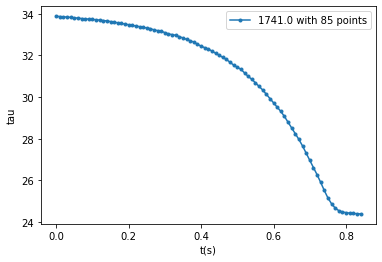

In [65]:
df_grouptest=df[df['group_id']==test_df.group_id.unique()[0]]
plt.plot(df_grouptest.index*1e-2, df_grouptest.tau, marker='.', label=f'{test_df.group_id.unique()[0]} with {df_grouptest.shape[0]} points' )
plt.xlabel('t(s)')
plt.ylabel('tau')
plt.legend()
plt.savefig(fname='figs/single_dense_10ms_1test.png')
print(test_df.group_id.unique()[0])
print(test_df.a.unique()[0])
print(test_df.b.unique()[0])
print(test_df.L.unique()[0])
print(df_grouptest.shape)

In [30]:
# Training process, give epochs(combined with batch_size)
max_epochs=50
single_dense_10ms=single_dense_model()
print('Single Dense')
checkpoint_path='checkpoint/10ms_single_dense'
history=compile_and_fit(single_dense_10ms, max_epochs, single_window_train, single_window_val, single_window_test, checkpoint_path)

Single Dense
Epoch 1/50
4888/4888 [==============================] - 44s 9ms/step - loss: 0.0097 - mean_absolute_error: 0.0467 - val_loss: 0.0044 - val_mean_absolute_error: 0.0383
Epoch 2/50
4888/4888 [==============================] - 33s 7ms/step - loss: 0.0015 - mean_absolute_error: 0.0214 - val_loss: 0.0032 - val_mean_absolute_error: 0.0361
Epoch 3/50
4888/4888 [==============================] - 32s 7ms/step - loss: 0.0012 - mean_absolute_error: 0.0186 - val_loss: 0.0019 - val_mean_absolute_error: 0.0317
Epoch 4/50
4888/4888 [==============================] - 29s 6ms/step - loss: 8.6894e-04 - mean_absolute_error: 0.0151 - val_loss: 0.0012 - val_mean_absolute_error: 0.0210
Epoch 5/50
4888/4888 [==============================] - 30s 6ms/step - loss: 6.3306e-04 - mean_absolute_error: 0.0132 - val_loss: 6.0306e-04 - val_mean_absolute_error: 0.0158
Epoch 6/50
4888/4888 [==============================] - 30s 6ms/step - loss: 4.8820e-04 - mean_absolute_error: 0.0121 - val_loss: 7.0745e-04

NameError: name 'single_dense' is not defined

In [31]:
print(single_dense_10ms.summary())
val_performance={}
performance={}
val_performance['single_dense_10ms']=single_dense_10ms.evaluate(single_window_test)
performance['single_dense_10ms']=single_dense_10ms.evaluate(single_window_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 80)                0         
                                                                 
 dense (Dense)               (None, 128)               10368     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
 reshape (Reshape)           (None, 1, 1)              0         
                                                                 
Total params: 18,689
Trainable params: 18,689
Non-trainable params: 0
_________________________________________________________________
None
924/924 [==============================] - 3s 4

Inputs shape (batch, time, features): (20, 5, 16)
Labels shape (batch, time, features): (20, 1, 1)
0:00:06.134392


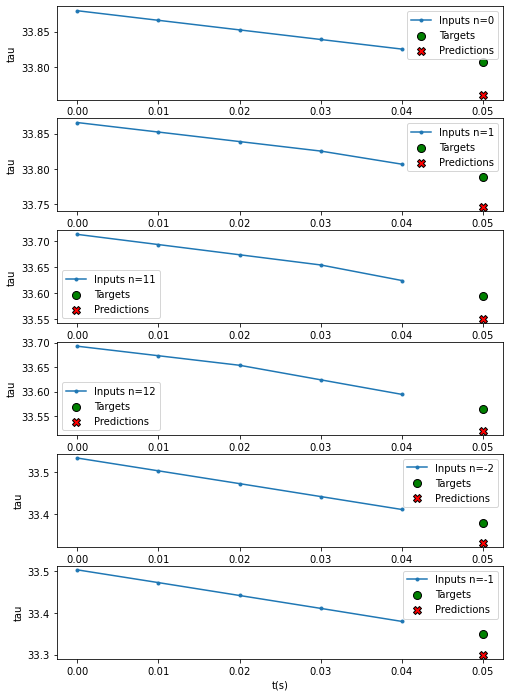

In [57]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in single_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
single_window.plot(nor_inputs,nor_labels,batch_size, interval, model=single_dense_10ms, plot_col='tau')
plt.savefig(fname='figs/single_dense_pred_1batch.png')

Inputs shape (batch, time, features): (20, 5, 16)
Labels shape (batch, time, features): (20, 1, 1)
Inputs shape (batch, time, features): (20, 5, 16)
Labels shape (batch, time, features): (20, 1, 1)
Inputs shape (batch, time, features): (20, 5, 16)
Labels shape (batch, time, features): (20, 1, 1)
Inputs shape (batch, time, features): (20, 5, 16)
Labels shape (batch, time, features): (20, 1, 1)
0:00:05.894626


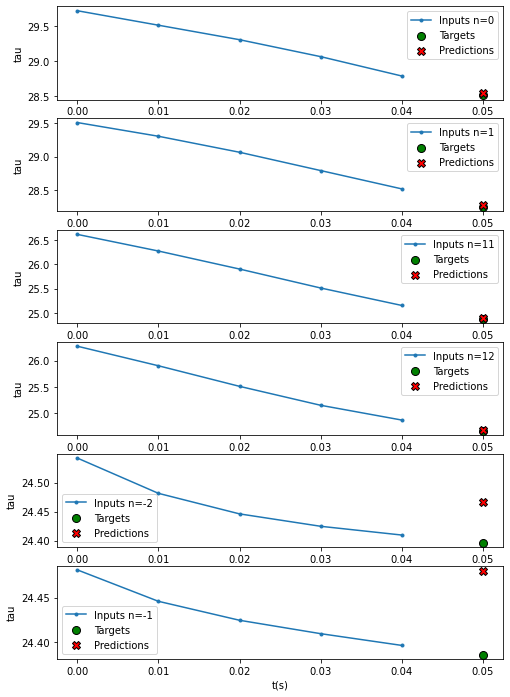

In [58]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in single_window_test.take(4):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
single_window.plot(nor_inputs,nor_labels,batch_size, interval, model=single_dense_10ms, plot_col='tau')
plt.savefig(fname='figs/single_dense_pred_4batch.png')

Inputs shape (batch, time, features): (20, 5, 16)
Labels shape (batch, time, features): (20, 1, 1)
Inputs shape (batch, time, features): (20, 5, 16)
Labels shape (batch, time, features): (20, 1, 1)
Inputs shape (batch, time, features): (20, 5, 16)
Labels shape (batch, time, features): (20, 1, 1)
0:00:05.466141


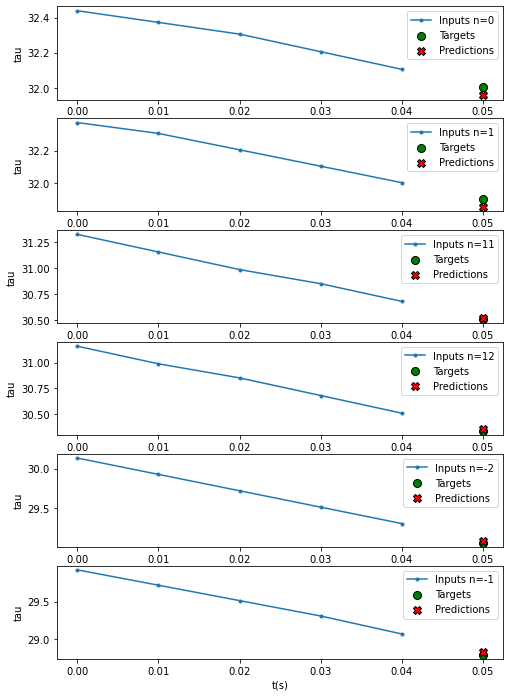

In [59]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in single_window_test.take(3):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
single_window.plot(nor_inputs,nor_labels,batch_size, interval, model=single_dense_10ms, plot_col='tau')
plt.savefig(fname='figs/single_dense_pred_3batch.png')

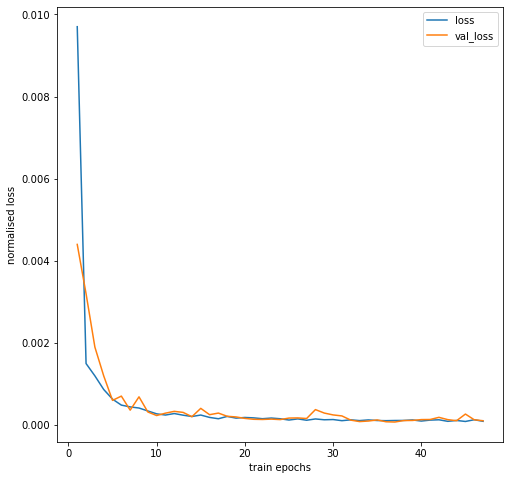

In [56]:
single_dense_loss=[0.0097, 0.0015, 0.0012, 8.6894e-04, 6.3306e-04, 4.8820e-04, 4.4422e-04, 4.1741e-04, 3.4606e-04, 2.7586e-04, 
                  2.4639e-04, 2.8291e-04, 2.4277e-04, 2.1088e-04, 2.4650e-04, 1.8871e-04, 1.5627e-04, 2.1294e-04, 1.7127e-04, 
                  1.8734e-04, 1.7759e-04, 1.5724e-04, 1.7322e-04, 1.5614e-04, 1.2461e-04, 1.5276e-04, 1.1970e-04, 1.5143e-04, 
                  1.3117e-04, 1.3701e-04, 1.0910e-04, 1.2971e-04, 1.1141e-04, 1.2801e-04, 1.1288e-04, 1.0943e-04, 1.1376e-04, 
                  1.1513e-04, 1.2732e-04, 9.9783e-05, 1.2318e-04, 1.3090e-04, 9.3428e-05, 1.1455e-04, 9.0137e-05, 1.3201e-04, 
                  9.3866e-05]
single_dense_val_loss=[0.0044, 0.0032, 0.0019, 0.0012, 6.0306e-04, 7.0745e-04, 3.6537e-04, 6.8962e-04, 3.2137e-04, 2.3425e-04,
                       2.9230e-04, 3.3634e-04, 3.1086e-04, 2.0649e-04, 4.0939e-04, 2.5504e-04, 2.9426e-04, 2.1609e-04, 2.0024e-04,
                       1.6494e-04, 1.4299e-04, 1.3867e-04, 1.4713e-04, 1.3560e-04, 1.7274e-04, 1.7644e-04, 1.6184e-04, 3.7900e-04,
                       2.9483e-04, 2.4948e-04, 2.2510e-04, 1.2296e-04, 8.7170e-05, 1.0034e-04, 1.2735e-04, 8.2619e-05, 7.6267e-05,
                       1.1210e-04, 1.1482e-04, 1.3563e-04, 1.3813e-04, 1.9046e-04, 1.3470e-04, 1.0861e-04, 2.7022e-04, 1.3129e-04, 
                       1.0779e-04]
single_epochs=np.arange(1, 48, 1)
plt.figure(figsize=(8,8))
plt.plot(single_epochs, single_dense_loss, label='loss')
plt.plot(single_epochs, single_dense_val_loss, label='val_loss')
plt.xlabel('train epochs')
plt.ylabel('normalised loss')
plt.legend()
plt.savefig(fname='figs/single_dense_10ms_loss.png')

In [63]:
#10 ms Window
batch_size=20
out_step=25
input_step=25
interval=10
multi_window=WindowGenerator(input_width=input_step, label_width=out_step, shift=out_step,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
print(multi_window)

multi_window_train=multi_window.make_dataset(train_df_nor, batch_size, is_training=True)
multi_window_val=multi_window.make_dataset(val_df_nor, batch_size, is_training=True)
multi_window_test=multi_window.make_dataset(test_df_nor, batch_size, is_training=False)
num_features=train_df_nor.shape[-1]
print(num_features)

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Label column name(s): ['tau']
0:00:29.547392
0:00:07.972332
0:00:03.707827
16


In [64]:
# Training process, give epochs(combined with batch_size)
max_epochs=50
multi_dense_10ms=multi_dense_model(out_step, num_features)
print('Multi Dense')
checkpoint_path='checkpoint/10ms_multi_dense'
history=compile_and_fit(multi_dense_10ms, max_epochs, multi_window_train, multi_window_val, multi_window_test, checkpoint_path)
print(multi_dense_10ms.summary())
val_performance['multi_dense_10ms']=multi_dense_10ms.evaluate(multi_window_test)
performance['multi_dense_10ms']=multi_dense_10ms.evaluate(multi_window_test)

Multi Dense
Epoch 1/50
2234/2234 [==============================] - 39s 17ms/step - loss: 0.0171 - mean_absolute_error: 0.0709 - val_loss: 0.0120 - val_mean_absolute_error: 0.0749
Epoch 2/50
2234/2234 [==============================] - 25s 11ms/step - loss: 0.0066 - mean_absolute_error: 0.0431 - val_loss: 0.0101 - val_mean_absolute_error: 0.0693
Epoch 3/50
2234/2234 [==============================] - 25s 11ms/step - loss: 0.0035 - mean_absolute_error: 0.0332 - val_loss: 0.0079 - val_mean_absolute_error: 0.0693
Epoch 4/50
2234/2234 [==============================] - 25s 11ms/step - loss: 0.0027 - mean_absolute_error: 0.0308 - val_loss: 0.0058 - val_mean_absolute_error: 0.0497
Epoch 5/50
2234/2234 [==============================] - 25s 11ms/step - loss: 0.0024 - mean_absolute_error: 0.0286 - val_loss: 0.0068 - val_mean_absolute_error: 0.0564
Epoch 6/50
2234/2234 [==============================] - 24s 11ms/step - loss: 0.0018 - mean_absolute_error: 0.0249 - val_loss: 0.0050 - val_mean_abs

Inputs shape (batch, time, features): (20, 25, 16)
Labels shape (batch, time, features): (20, 25, 1)
0:00:03.519824


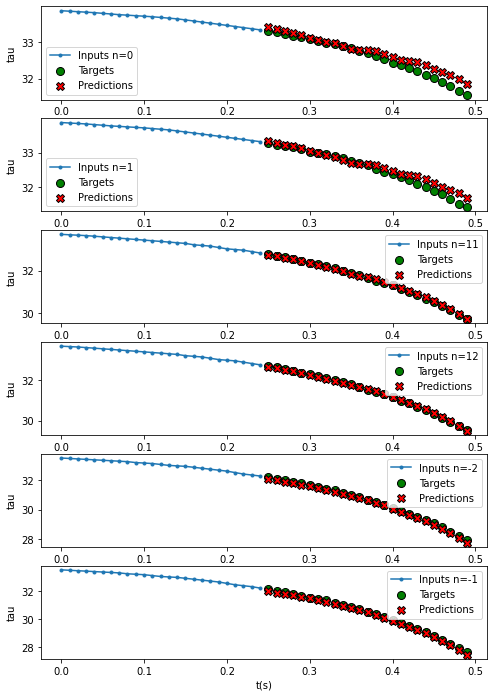

In [66]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_10ms, plot_col='tau')
plt.savefig(fname='figs/multi_dense_pred_1batch.png')

Inputs shape (batch, time, features): (20, 25, 16)
Labels shape (batch, time, features): (20, 25, 1)
Inputs shape (batch, time, features): (16, 25, 16)
Labels shape (batch, time, features): (16, 25, 1)
0:00:03.317995


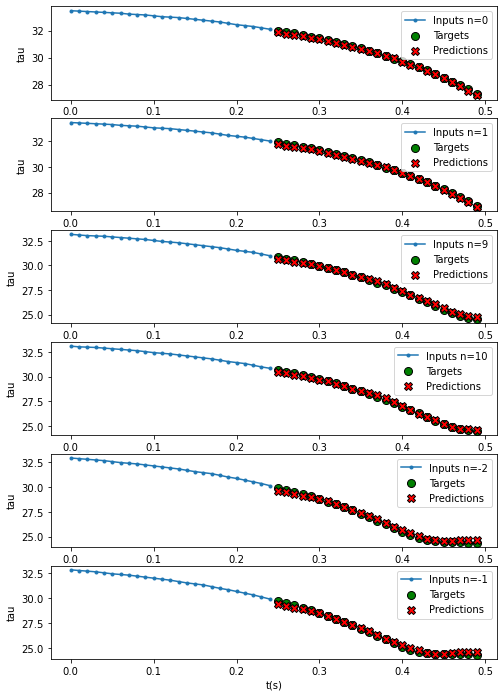

In [67]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(2):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_10ms, plot_col='tau')
plt.savefig(fname='figs/multi_dense_pred_2batch.png')

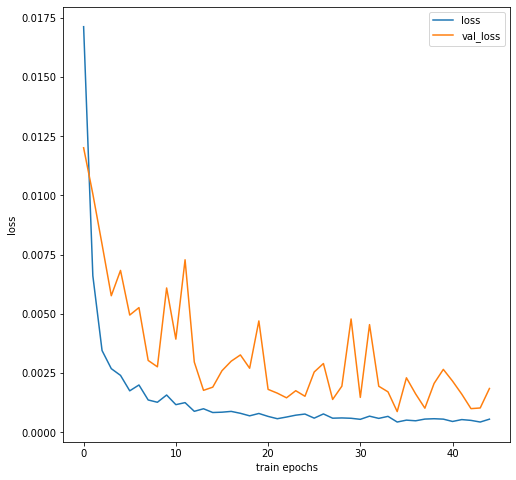

In [68]:
multi_loss=pd.read_csv('checkpoint/10ms_multi_densemodel_history_log.csv')
plt.figure(figsize=(8,8))
plt.plot(multi_loss.epoch, multi_loss.loss, label='loss')
plt.plot(multi_loss.epoch, multi_loss.val_loss, label='val_loss')
plt.xlabel('train epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig(fname='figs/multi_dense_10ms_loss.png')

In [ ]:
#Change 10 ms into 5 ms

In [70]:
# 5 ms
df,N=Datasample(total_df1).add_features(Nt)
print(df.shape)
num_columns=df.shape[-1]
column_indices={name: i for i, name in enumerate(df.columns)}
print(num_columns)
print(column_indices)

train_df, val_df, test_df, N_new=Datasample(df).split_df(N)
print(f'train_df.shape={train_df.shape}')
print(f'val_df.shape={val_df.shape}')
print(f'test_df.shape={test_df.shape}')
train_groups=train_df.group_id.unique()
val_groups=val_df.group_id.unique()
test_groups=test_df.group_id.unique()
print(len(train_groups))
print(len(val_groups))
print(len(test_groups))

train_df_nor, val_df_nor, test_df_nor, train_mean, train_std=Datasample(df).normalization(train_df, val_df, test_df)
print(f'train_df_nor.shape = {train_df_nor.shape}')
print(f'val_df_nor.shape = {val_df_nor.shape}')
print(f'test_df_nor.shape = {test_df_nor.shape}')
print(f'train_mean = {train_mean}')
print(f'train_std = {train_std}')

0:00:22.118813
(269902, 16)
16
{'group_id': 0, 'a': 1, 'b': 2, 'L': 3, 'dtau': 4, 'dtau2': 5, 'theta': 6, 'dtheta': 7, 'dtheta2': 8, 'U': 9, 'dU': 10, 'dU2': 11, 'V': 12, 'dV': 13, 'dV2': 14, 'tau': 15}
train_df.shape=(184034, 16)
val_df.shape=(51015, 16)
test_df.shape=(34853, 16)
1222
349
174
train_df_nor.shape = (184034, 16)
val_df_nor.shape = (51015, 16)
test_df_nor.shape = (34853, 16)
train_mean = group_id       682.276976
a                0.005721
b                0.012525
L                0.024865
dtau             0.077047
dtau2            0.154012
theta       612450.520969
dtheta       20443.221216
dtheta2      40538.421626
U                0.244135
dU              -0.004460
dU2             -0.008850
V                0.896207
dV              -0.015911
dV2             -0.015911
tau             32.112341
dtype: float64
train_std = group_id    3.921071e+02
a           2.669897e-03
b           4.380184e-03
L           1.000000e+00
dtau        1.217403e-01
dtau2       2.424044e-01
th

1741.0
0.00214288
0.00991842
0.0248655
(170, 16)


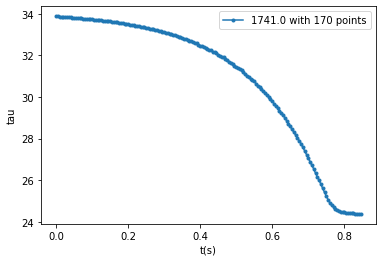

In [71]:
df_grouptest=df[df['group_id']==test_df.group_id.unique()[0]]
plt.plot(df_grouptest.index*5e-3, df_grouptest.tau, marker='.', label=f'{test_df.group_id.unique()[0]} with {df_grouptest.shape[0]} points' )
plt.xlabel('t(s)')
plt.ylabel('tau')
plt.legend()
print(test_df.group_id.unique()[0])
print(test_df.a.unique()[0])
print(test_df.b.unique()[0])
print(test_df.L.unique()[0])
print(df_grouptest.shape)

In [72]:
#5 ms Window
batch_size=80
out_step=25
input_step=25
interval=5
multi_window=WindowGenerator(input_width=input_step, label_width=out_step, shift=out_step,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
print(multi_window)

multi_window_train=multi_window.make_dataset(train_df_nor, batch_size, is_training=True)
multi_window_val=multi_window.make_dataset(val_df_nor, batch_size, is_training=True)
multi_window_test=multi_window.make_dataset(test_df_nor, batch_size, is_training=False)
num_features=train_df_nor.shape[-1]
print(num_features)

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Label column name(s): ['tau']
0:00:30.384069
0:00:07.857187
0:00:03.969843
16


In [73]:
# Training process, give epochs(combined with batch_size)
max_epochs=50
multi_dense_5ms=multi_dense_model(out_step, num_features)
print('Multi Dense')
checkpoint_path='checkpoint/5ms_multi_dense'
history=compile_and_fit(multi_dense_5ms, max_epochs, multi_window_train, multi_window_val, multi_window_test, checkpoint_path)
print(multi_dense_5ms.summary())
val_performance['multi_dense_5ms']=multi_dense_5ms.evaluate(multi_window_test)
performance['multi_dense_5ms']=multi_dense_5ms.evaluate(multi_window_test)

Multi Dense
Epoch 1/50
2241/2241 [==============================] - 47s 20ms/step - loss: 0.0104 - mean_absolute_error: 0.0524 - val_loss: 0.0064 - val_mean_absolute_error: 0.0471
Epoch 2/50
2241/2241 [==============================] - 32s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0258 - val_loss: 0.0051 - val_mean_absolute_error: 0.0497
Epoch 3/50
2241/2241 [==============================] - 31s 14ms/step - loss: 0.0034 - mean_absolute_error: 0.0282 - val_loss: 0.0032 - val_mean_absolute_error: 0.0393
Epoch 4/50
2241/2241 [==============================] - 30s 13ms/step - loss: 0.0012 - mean_absolute_error: 0.0205 - val_loss: 0.0025 - val_mean_absolute_error: 0.0319
Epoch 5/50
2241/2241 [==============================] - 32s 14ms/step - loss: 0.0015 - mean_absolute_error: 0.0210 - val_loss: 0.0076 - val_mean_absolute_error: 0.0575
Epoch 6/50
2241/2241 [==============================] - 31s 14ms/step - loss: 0.0013 - mean_absolute_error: 0.0207 - val_loss: 9.8959e-04 - val_mean

Inputs shape (batch, time, features): (80, 25, 16)
Labels shape (batch, time, features): (80, 25, 1)
0:00:03.722308


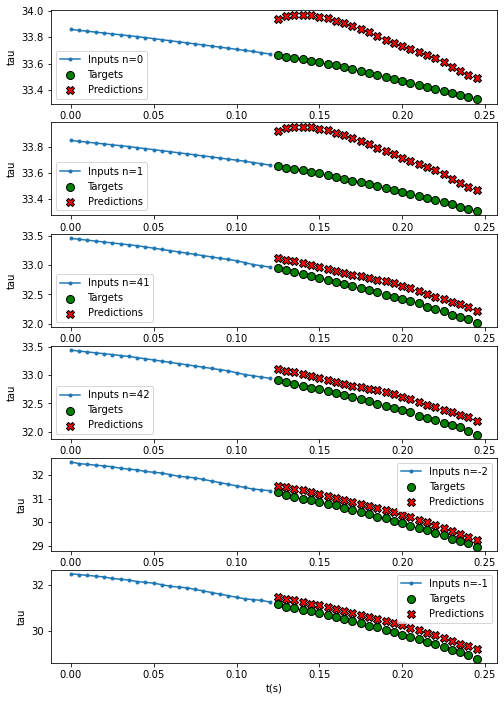

In [74]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_5ms, plot_col='tau')
plt.savefig(fname='figs/5ms_multi_dense_pred_1batch.png')

Inputs shape (batch, time, features): (80, 25, 16)
Labels shape (batch, time, features): (80, 25, 1)
Inputs shape (batch, time, features): (41, 25, 16)
Labels shape (batch, time, features): (41, 25, 1)
0:00:03.814773


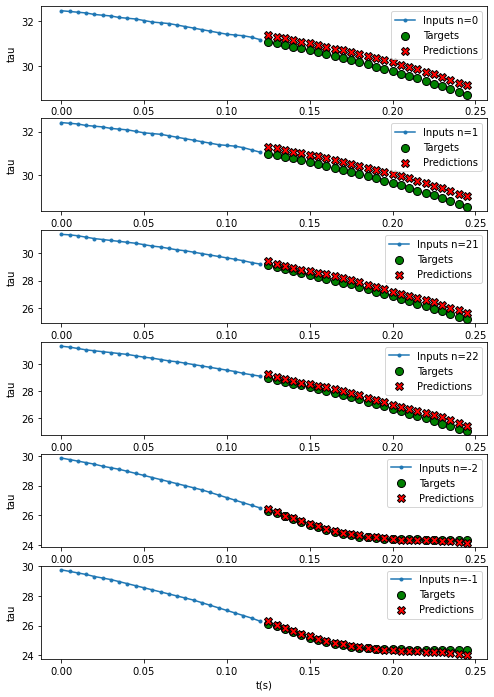

In [75]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(2):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_5ms, plot_col='tau')
plt.savefig(fname='figs/5ms_multi_dense_pred_2batch.png')

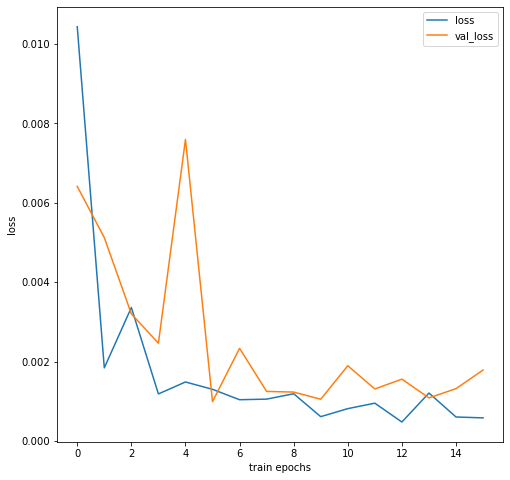

In [76]:
multi_loss=pd.read_csv('checkpoint/5ms_multi_densemodel_history_log.csv')
plt.figure(figsize=(8,8))
plt.plot(multi_loss.epoch, multi_loss.loss, label='loss')
plt.plot(multi_loss.epoch, multi_loss.val_loss, label='val_loss')
plt.xlabel('train epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig(fname='figs/multi_dense_5ms_loss.png')

In [77]:
# Create a small batch 
batch_size=50
out_step=25
input_step=25
interval=5
multi_window=WindowGenerator(input_width=input_step, label_width=out_step, shift=out_step,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
print(multi_window)

multi_window_train=multi_window.make_dataset(train_df_nor, batch_size, is_training=True)
multi_window_val=multi_window.make_dataset(val_df_nor, batch_size, is_training=True)
multi_window_test=multi_window.make_dataset(test_df_nor, batch_size, is_training=False)
num_features=train_df_nor.shape[-1]
print(num_features)

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Label column name(s): ['tau']
0:00:29.216118
0:00:10.150613
0:00:03.981738
16


In [78]:
# Training process, give epochs(combined with batch_size)
max_epochs=50
multi_dense_5ms_50=multi_dense_model(out_step, num_features)
print('Multi Dense')
checkpoint_path='checkpoint/50_5ms_multi_dense'
history=compile_and_fit(multi_dense_5ms_50, max_epochs, multi_window_train, multi_window_val, multi_window_test, checkpoint_path)
print(multi_dense_5ms_50.summary())
val_performance['multi_dense_5ms_50']=multi_dense_5ms_50.evaluate(multi_window_test)
performance['multi_dense_5ms_50']=multi_dense_5ms_50.evaluate(multi_window_test)

Multi Dense
Epoch 1/50
3004/3004 [==============================] - 53s 17ms/step - loss: 0.0093 - mean_absolute_error: 0.0472 - val_loss: 0.0074 - val_mean_absolute_error: 0.0674
Epoch 2/50
3004/3004 [==============================] - 35s 12ms/step - loss: 0.0026 - mean_absolute_error: 0.0261 - val_loss: 0.0039 - val_mean_absolute_error: 0.0444
Epoch 3/50
3004/3004 [==============================] - 34s 11ms/step - loss: 0.0016 - mean_absolute_error: 0.0216 - val_loss: 0.0035 - val_mean_absolute_error: 0.0459
Epoch 4/50
3004/3004 [==============================] - 38s 13ms/step - loss: 0.0011 - mean_absolute_error: 0.0190 - val_loss: 0.0020 - val_mean_absolute_error: 0.0292
Epoch 5/50
3004/3004 [==============================] - 36s 12ms/step - loss: 0.0011 - mean_absolute_error: 0.0186 - val_loss: 0.0016 - val_mean_absolute_error: 0.0273
Epoch 6/50
3004/3004 [==============================] - 36s 12ms/step - loss: 8.4552e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0016 - val_mean

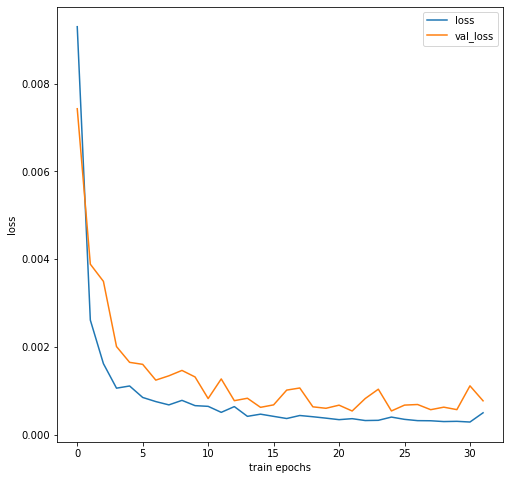

In [79]:
multi_loss=pd.read_csv('checkpoint/50_5ms_multi_densemodel_history_log.csv')
plt.figure(figsize=(8,8))
plt.plot(multi_loss.epoch, multi_loss.loss, label='loss')
plt.plot(multi_loss.epoch, multi_loss.val_loss, label='val_loss')
plt.xlabel('train epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig(fname='figs/50_5ms_multi_dense_loss.png')

Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
0:00:05.535452


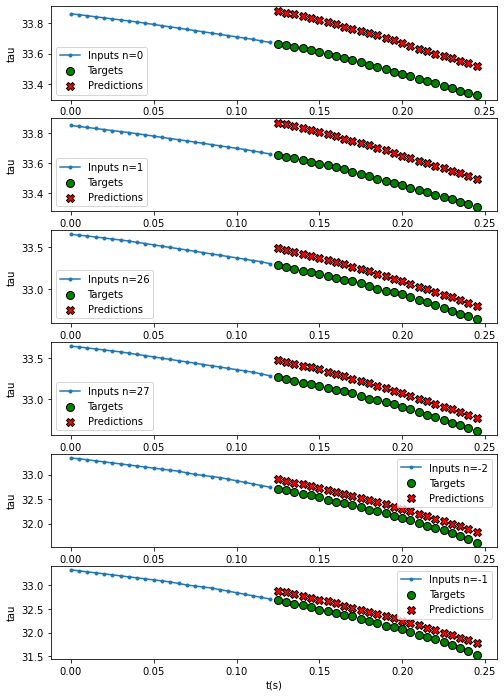

In [80]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_5ms_50, plot_col='tau')
plt.savefig(fname='figs/50_5ms_multi_dense_pred_1batch.png')

Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
Inputs shape (batch, time, features): (21, 25, 16)
Labels shape (batch, time, features): (21, 25, 1)
0:00:05.207474


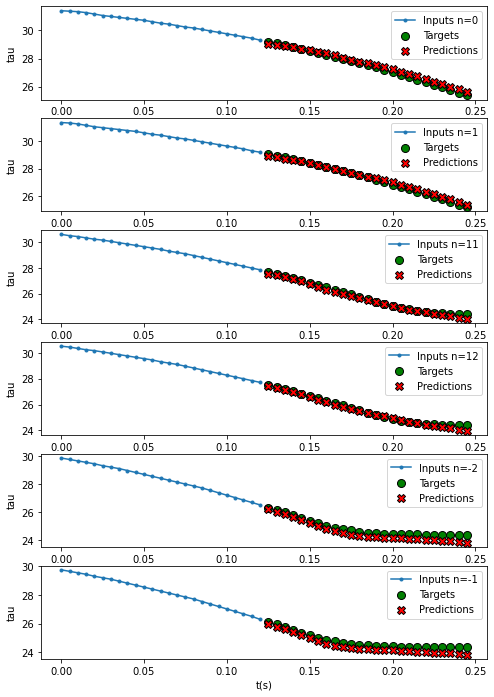

In [81]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(3):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_5ms_50, plot_col='tau')
plt.savefig(fname='figs/50_5ms_multi_dense_pred_3batch.png')

Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
0:00:05.333093


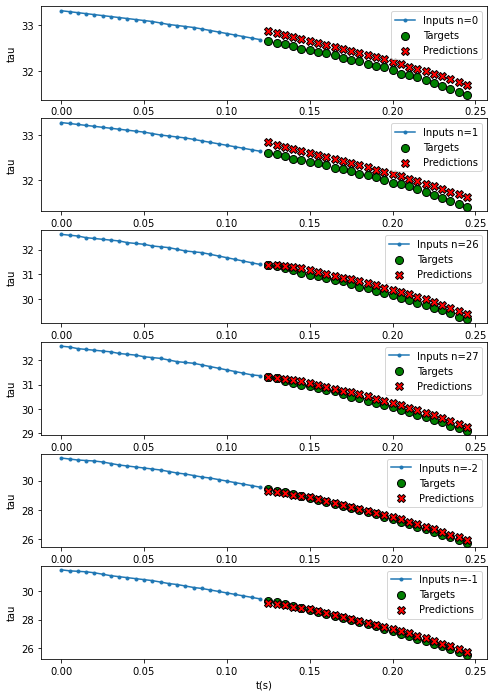

In [82]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(2):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_5ms_50, plot_col='tau')
plt.savefig(fname='figs/50_5ms_multi_dense_pred_2batch.png')

In [ ]:
# For 1 ms --> Only 500 groups are tested

In [84]:
#Too big --> split into three parts
Nt=5000
n=500
df=total_df[0:Nt*n]
df.shape

(2500000, 10)

In [85]:
# 1 ms
df,N=Datasample(df).add_features(Nt)
print(df.shape)
num_columns=df.shape[-1]
column_indices={name: i for i, name in enumerate(df.columns)}
print(num_columns)
print(column_indices)

train_df, val_df, test_df, N_new=Datasample(df).split_df(N)
print(f'train_df.shape={train_df.shape}')
print(f'val_df.shape={val_df.shape}')
print(f'test_df.shape={test_df.shape}')
train_groups=train_df.group_id.unique()
val_groups=val_df.group_id.unique()
test_groups=test_df.group_id.unique()
print(len(train_groups))
print(len(val_groups))
print(len(test_groups))

train_df_nor, val_df_nor, test_df_nor, train_mean, train_std=Datasample(df).normalization(train_df, val_df, test_df)
print(f'train_df_nor.shape = {train_df_nor.shape}')
print(f'val_df_nor.shape = {val_df_nor.shape}')
print(f'test_df_nor.shape = {test_df_nor.shape}')
print(f'train_mean = {train_mean}')
print(f'train_std = {train_std}')

0:00:07.840482
(342699, 16)
16
{'group_id': 0, 'a': 1, 'b': 2, 'L': 3, 'dtau': 4, 'dtau2': 5, 'theta': 6, 'dtheta': 7, 'dtheta2': 8, 'U': 9, 'dU': 10, 'dU2': 11, 'V': 12, 'dV': 13, 'dV2': 14, 'tau': 15}
train_df.shape=(240985, 16)
val_df.shape=(69616, 16)
test_df.shape=(32098, 16)
315
89
44
train_df_nor.shape = (240985, 16)
val_df_nor.shape = (69616, 16)
test_df_nor.shape = (32098, 16)
train_mean = group_id       181.389555
a                0.005710
b                0.011887
L                0.024865
dtau             0.014122
dtau2            0.028242
theta       541486.883113
dtheta        3558.821312
dtheta2       7106.034794
U                0.238059
dU              -0.000830
dU2             -0.001657
V                0.825043
dV              -0.002882
dV2             -0.002882
tau             32.229627
dtype: float64
train_std = group_id    1.068635e+02
a           2.674489e-03
b           4.090035e-03
L           1.000000e+00
dtau        2.270274e-02
dtau2       4.455586e-02
theta

455.0
0.0038539
0.0106132
0.0248655
(786, 16)


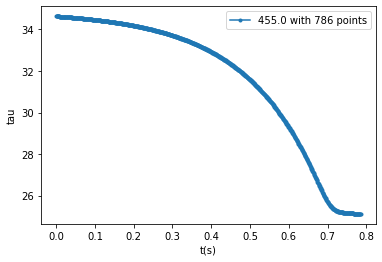

In [87]:
df_grouptest=df[df['group_id']==test_df.group_id.unique()[0]]
plt.plot(df_grouptest.index*1e-3, df_grouptest.tau, marker='.', label=f'{test_df.group_id.unique()[0]} with {df_grouptest.shape[0]} points' )
plt.xlabel('t(s)')
plt.ylabel('tau')
plt.legend()
plt.savefig(fname='figs/multi_dense_1ms_1test.png')
print(test_df.group_id.unique()[0])
print(test_df.a.unique()[0])
print(test_df.b.unique()[0])
print(test_df.L.unique()[0])
print(df_grouptest.shape)

In [89]:
# Create a small batch 
batch_size=100
out_step=25
input_step=25
interval=1
multi_window=WindowGenerator(input_width=input_step, label_width=out_step, shift=out_step,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
print(multi_window)

multi_window_train=multi_window.make_dataset(train_df_nor, batch_size, is_training=True)
multi_window_val=multi_window.make_dataset(val_df_nor, batch_size, is_training=True)
multi_window_test=multi_window.make_dataset(test_df_nor, batch_size, is_training=False)
num_features=train_df_nor.shape[-1]
print(num_features)

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Label column name(s): ['tau']
0:00:12.136301
0:00:02.682379
0:00:01.437930
16


In [90]:
# Training process, give epochs(combined with batch_size)
max_epochs=50
multi_dense_1ms=multi_dense_model(out_step, num_features)
print('Multi Dense')
checkpoint_path='checkpoint/1ms_multi_dense'
history=compile_and_fit(multi_dense_1ms, max_epochs, multi_window_train, multi_window_val, multi_window_test, checkpoint_path)
print(multi_dense_1ms.summary())
val_performance['multi_dense_1ms']=multi_dense_1ms.evaluate(multi_window_test)
performance['multi_dense_1ms']=multi_dense_1ms.evaluate(multi_window_test)

Multi Dense
Epoch 1/50
2382/2382 [==============================] - 28s 11ms/step - loss: 0.0100 - mean_absolute_error: 0.0447 - val_loss: 0.0013 - val_mean_absolute_error: 0.0279
Epoch 2/50
2382/2382 [==============================] - 27s 11ms/step - loss: 0.0018 - mean_absolute_error: 0.0212 - val_loss: 0.0097 - val_mean_absolute_error: 0.0664
Epoch 3/50
2382/2382 [==============================] - 26s 11ms/step - loss: 7.0000e-04 - mean_absolute_error: 0.0141 - val_loss: 9.6362e-04 - val_mean_absolute_error: 0.0217
Epoch 4/50
2382/2382 [==============================] - 23s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0168 - val_loss: 4.8954e-04 - val_mean_absolute_error: 0.0162
Epoch 5/50
2382/2382 [==============================] - 21s 9ms/step - loss: 6.1785e-04 - mean_absolute_error: 0.0135 - val_loss: 3.5901e-04 - val_mean_absolute_error: 0.0150
Epoch 6/50
2382/2382 [==============================] - 24s 10ms/step - loss: 6.3829e-04 - mean_absolute_error: 0.0127 - val_loss

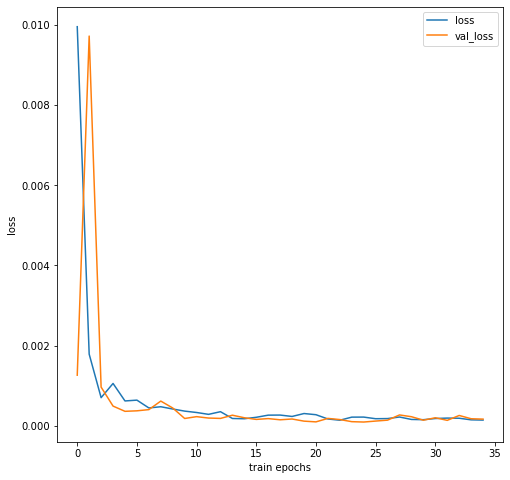

In [91]:
multi_loss=pd.read_csv('checkpoint/1ms_multi_densemodel_history_log.csv')
plt.figure(figsize=(8,8))
plt.plot(multi_loss.epoch, multi_loss.loss, label='loss')
plt.plot(multi_loss.epoch, multi_loss.val_loss, label='val_loss')
plt.xlabel('train epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig(fname='figs/1ms_multi_dense_loss.png')

Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
0:00:01.032089


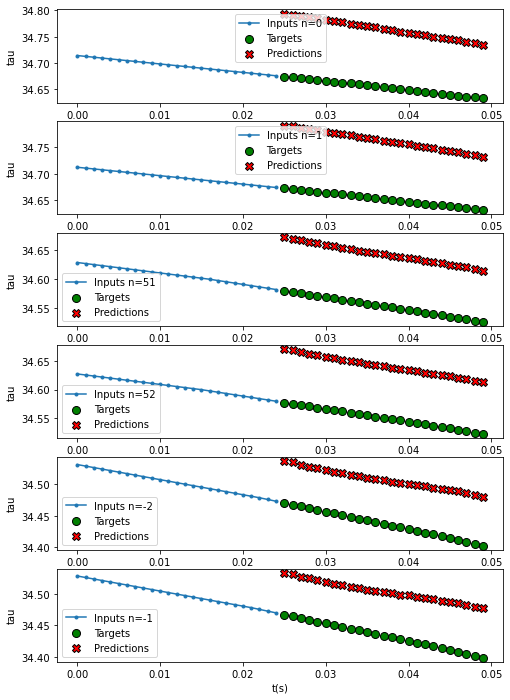

In [92]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_1ms, plot_col='tau')
plt.savefig(fname='figs/1ms_multi_dense_pred_1batch.png')

Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
0:00:00.900507


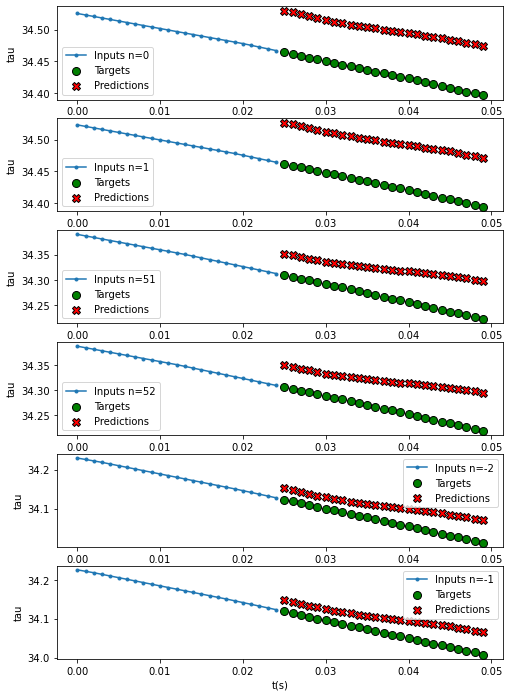

In [96]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(2):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_1ms, plot_col='tau')
plt.savefig(fname='figs/1ms_multi_dense_pred_2batch.png')

Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
0:00:01.165704


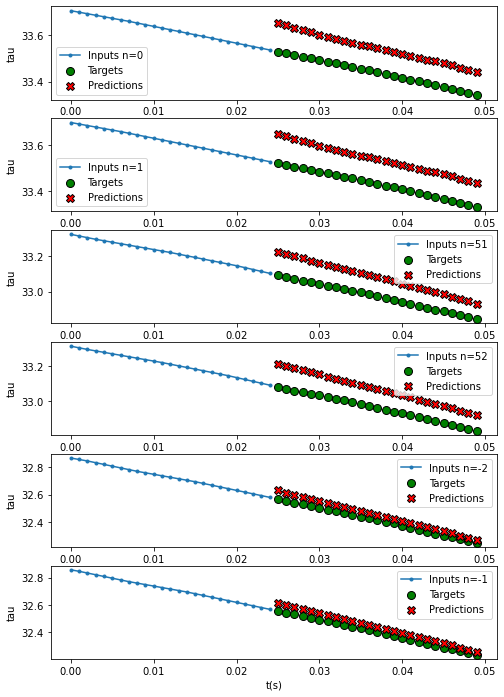

In [93]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(4):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_1ms, plot_col='tau')
plt.savefig(fname='figs/1ms_multi_dense_pred_4batch.png')

Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
0:00:00.968427


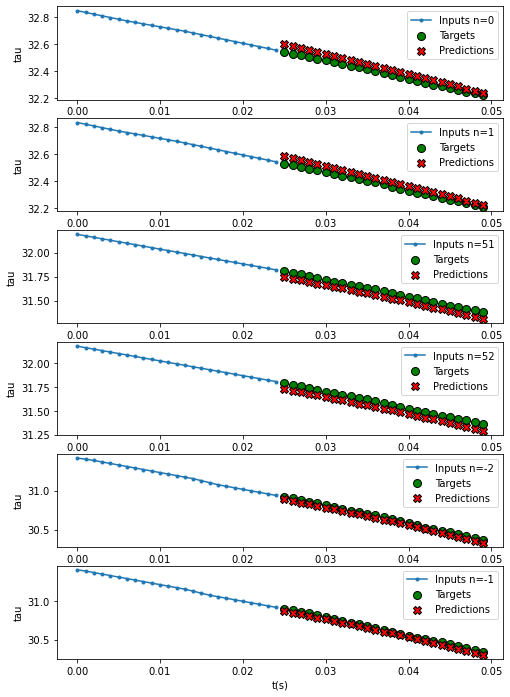

In [94]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(5):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_1ms, plot_col='tau')
plt.savefig(fname='figs/1ms_multi_dense_pred_5batch.png')

Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
Inputs shape (batch, time, features): (100, 25, 16)
Labels shape (batch, time, features): (100, 25, 1)
0:00:01.244264


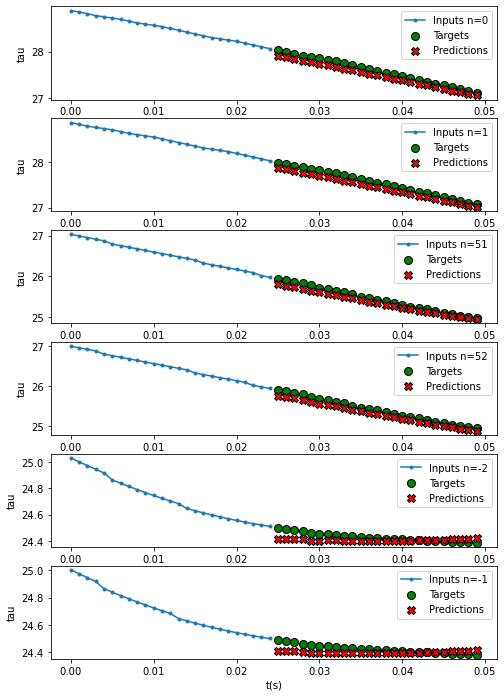

In [95]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(7):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
multi_window.plot(nor_inputs,nor_labels,batch_size, interval, model=multi_dense_1ms, plot_col='tau')
plt.savefig(fname='figs/1ms_multi_dense_pred_7batch.png')

In [22]:
# Generate multi_window: multiple steps output
batch_size=10
out_step=25
multi_window=WindowGenerator(input_width=25, label_width=out_step, shift=out_step,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
print(multi_window)

multi_window_train=multi_window.make_dataset(train_df_nor, batch_size, is_training=True)
multi_window_val=multi_window.make_dataset(val_df_nor, batch_size, is_training=True)
multi_window_test=multi_window.make_dataset(test_df_nor, batch_size, is_training=False)
num_features=train_df_nor.shape[-1]
print(num_features)

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Label column name(s): ['tau']
0:00:14.727546
0:00:03.742453
0:00:01.820162
16


In [9]:
#For 5ms
# Generate multi_window: multiple steps output
batch_size=50
out_step=30
mul_window=WindowGenerator(input_width=20, label_width=out_step, shift=out_step,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
print(mul_window)

mul_window_train=mul_window.make_dataset(train_df_nor, batch_size, is_training=True)
mul_window_val=mul_window.make_dataset(val_df_nor, batch_size, is_training=True)
mul_window_test=mul_window.make_dataset(test_df_nor, batch_size, is_training=False)
num_features=train_df_nor.shape[-1]
print(num_features)

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49]
Label column name(s): ['tau']


2022-09-19 14:58:03.643585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /quanta1/home/sang/miniconda/envs/tf2/lib:/quanta1/home/sang/miniconda3/lib:/trinity/opt/apps/software/gcc/gcc-10.2.0/lib64:/trinity/opt/apps/software/gcc/gcc-10.2.0/lib:/trinity/opt/apps/software/libzstd/zstd-1.3.7/buildHere/../lib
2022-09-19 14:58:03.643628: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-19 14:58:03.643655: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gpu014.cluster): /proc/driver/nvidia/version does not exist
2022-09-19 14:58:03.644016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

0:00:27.760944
0:00:07.993073
0:00:03.417588
16


Inputs shape (batch, time, features): (50, 20, 16)
Labels shape (batch, time, features): (50, 30, 1)
0:00:02.679648


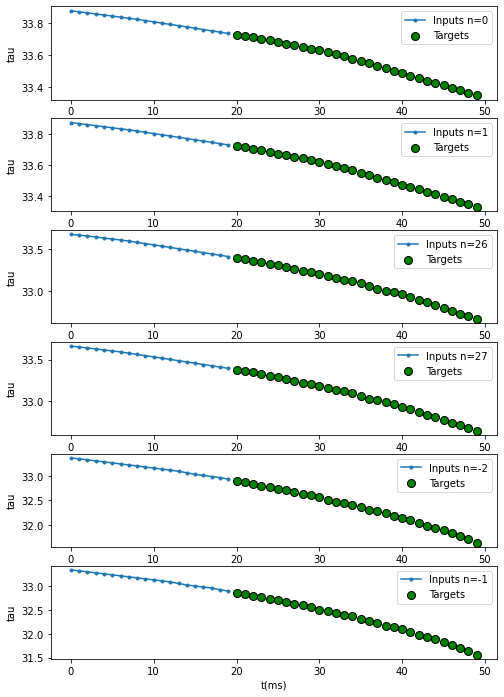

In [10]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in mul_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
mul_window.plot(nor_inputs,nor_labels,batch_size, plot_col='tau')

1741.0
(170, 16)


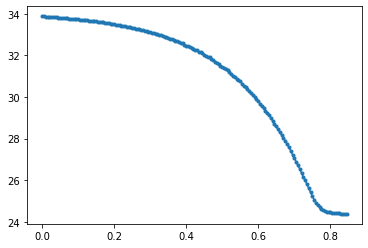

In [22]:
df_grouptest=df[df['group_id']==test_df.group_id.unique()[0]]
plt.plot(df_grouptest.index*5e-3, df_grouptest.tau, marker='.')
print(test_df.group_id.unique()[0])
print(df_grouptest.shape)

In [12]:
def compile_and_fit(model,max_epochs, window_train,window_val,window_test, patience=10):
    early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')
    model.compile(loss=MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[MeanAbsoluteError()])
    history=model.fit(window_train, epochs=max_epochs,
                    validation_data=window_val,
                    callbacks=[early_stopping])
    return history

# Build model
# Dense
def multi_dense_model(out_step, num_features):
    model=Sequential(
        [#Shape [batch, point, features] --> [batch, 1, features] take the last point
         layers.Lambda(lambda x: x[:,-1:,:]),
         layers.Dense(units=256, activation='relu'),
         layers.Dense(units=128, activation='relu'),
         layers.Dense(units=out_step*num_features,
                      kernel_initializer=tf.initializers.zeros()),
         layers.Reshape([out_step, num_features])])
    return model

In [13]:
# Training process, give epochs(combined with batch_size)
max_epochs=50
#for tau prediction, the num_features is 1
mul_dense=multi_dense_model(out_step, 1)
print('Multi Dense')
history=compile_and_fit(mul_dense, max_epochs, mul_window_train, mul_window_val, mul_window_test)
print(mul_dense.summary())
val_performance['Mul_Dense_5ms_5000']=mul_dense.evaluate(mul_window_test)
performance['Mul_Dense_5ms_5000']=mul_dense.evaluate(mul_window_test)

Multi Dense
Epoch 1/50
3004/3004 [==============================] - 44s 14ms/step - loss: 0.0094 - mean_absolute_error: 0.0481 - val_loss: 0.0073 - val_mean_absolute_error: 0.0583
Epoch 2/50
3004/3004 [==============================] - 31s 10ms/step - loss: 0.0037 - mean_absolute_error: 0.0289 - val_loss: 0.0057 - val_mean_absolute_error: 0.0567
Epoch 3/50
3004/3004 [==============================] - 32s 11ms/step - loss: 0.0017 - mean_absolute_error: 0.0220 - val_loss: 0.0050 - val_mean_absolute_error: 0.0555
Epoch 4/50
3004/3004 [==============================] - 32s 11ms/step - loss: 0.0017 - mean_absolute_error: 0.0224 - val_loss: 0.0040 - val_mean_absolute_error: 0.0484
Epoch 5/50
3004/3004 [==============================] - 32s 11ms/step - loss: 0.0014 - mean_absolute_error: 0.0203 - val_loss: 0.0031 - val_mean_absolute_error: 0.0412
Epoch 6/50
3004/3004 [==============================] - 30s 10ms/step - loss: 9.1296e-04 - mean_absolute_error: 0.0177 - val_loss: 0.0018 - val_mean

NameError: name 'val_performance' is not defined

In [14]:
val_performance={}
performance={}
val_performance['Mul_Dense_5ms_2000']=mul_dense.evaluate(mul_window_test)
performance['Mul_Dense_5ms_2000']=mul_dense.evaluate(mul_window_test)

626/626 [==============================] - 3s 5ms/step - loss: 0.0818 - mean_absolute_error: 0.1948


Inputs shape (batch, time, features): (50, 20, 16)
Labels shape (batch, time, features): (50, 30, 1)
0:00:03.290891


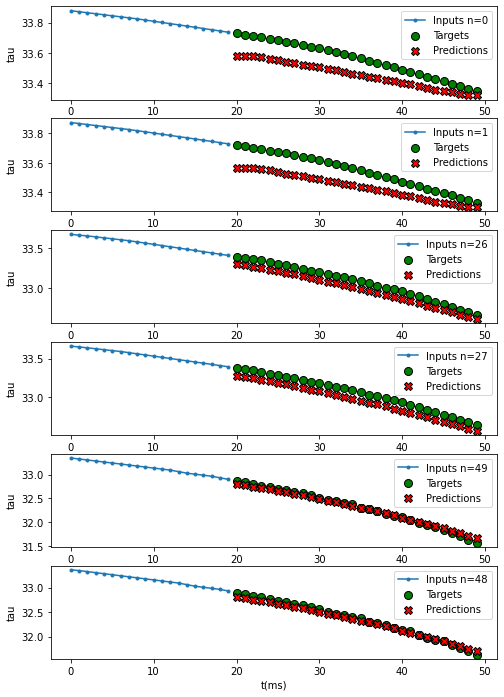

In [20]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in mul_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
mul_window.plot(nor_inputs,nor_labels,batch_size, model=mul_dense,plot_col='tau')

Inputs shape (batch, time, features): (50, 20, 16)
Labels shape (batch, time, features): (50, 30, 1)
Inputs shape (batch, time, features): (50, 20, 16)
Labels shape (batch, time, features): (50, 30, 1)
Inputs shape (batch, time, features): (21, 20, 16)
Labels shape (batch, time, features): (21, 30, 1)
0:00:03.293468


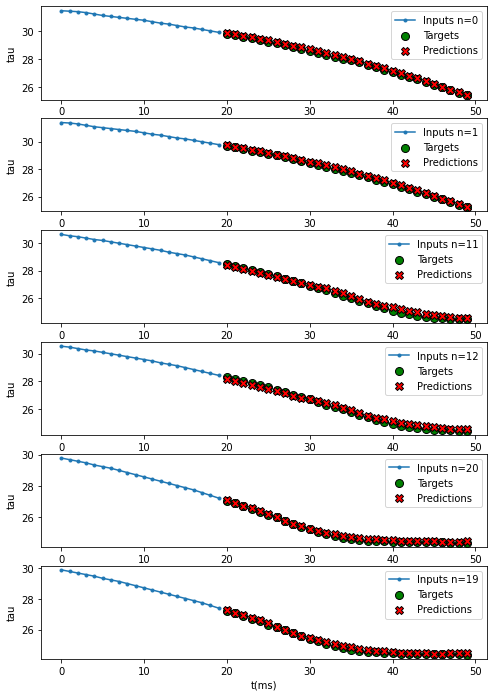

In [21]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in mul_window_test.take(3):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
mul_window.plot(nor_inputs,nor_labels,batch_size, model=mul_dense,plot_col='tau')

In [23]:
# Generate multi_window: multiple steps output
batch_size=50
out_step=25
multi_window=WindowGenerator(input_width=25, label_width=out_step, shift=out_step,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
print(multi_window)

multi_window_train=multi_window.make_dataset(train_df_nor, batch_size, is_training=True)
multi_window_val=multi_window.make_dataset(val_df_nor, batch_size, is_training=True)
multi_window_test=multi_window.make_dataset(test_df_nor, batch_size, is_training=False)
num_features=train_df_nor.shape[-1]
print(num_features)

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Label column name(s): ['tau']
0:00:27.352251
0:00:08.337088
0:00:03.934739
16


In [24]:
# Training process, give epochs(combined with batch_size)
max_epochs=50
#for tau prediction, the num_features is 1
multi_dense=multi_dense_model(out_step, 1)
print('Multi Dense')
history=compile_and_fit(multi_dense, max_epochs, multi_window_train, multi_window_val, multi_window_test)
print(multi_dense.summary())

Multi Dense
Epoch 1/50
3004/3004 [==============================] - 44s 15ms/step - loss: 0.0086 - mean_absolute_error: 0.0460 - val_loss: 0.0107 - val_mean_absolute_error: 0.0816
Epoch 2/50
3004/3004 [==============================] - 31s 10ms/step - loss: 0.0029 - mean_absolute_error: 0.0267 - val_loss: 0.0073 - val_mean_absolute_error: 0.0689
Epoch 3/50
3004/3004 [==============================] - 31s 10ms/step - loss: 0.0014 - mean_absolute_error: 0.0212 - val_loss: 0.0023 - val_mean_absolute_error: 0.0328
Epoch 4/50
3004/3004 [==============================] - 32s 11ms/step - loss: 0.0013 - mean_absolute_error: 0.0202 - val_loss: 0.0018 - val_mean_absolute_error: 0.0254
Epoch 5/50
3004/3004 [==============================] - 33s 11ms/step - loss: 0.0010 - mean_absolute_error: 0.0185 - val_loss: 0.0017 - val_mean_absolute_error: 0.0274
Epoch 6/50
3004/3004 [==============================] - 32s 11ms/step - loss: 8.5955e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0011 - val_mean

InvalidArgumentError: Graph execution error:

Detected at node 'mean_absolute_error/sub' defined at (most recent call last):
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_60192/1815518229.py", line 8, in <cell line: 8>
      val_performance['Multi_Dense_5ms_2000']=mul_dense.evaluate(multi_window_test)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/engine/training.py", line 1756, in evaluate
      tmp_logs = self.test_function(iterator)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/engine/training.py", line 1557, in test_function
      return step_function(self, iterator)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/engine/training.py", line 1546, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/engine/training.py", line 1535, in run_step
      outputs = model.test_step(data)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/engine/training.py", line 1502, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/engine/training.py", line 987, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 501, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 646, in update_state
      matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/quanta1/home/sang/miniconda3/envs/tf2/lib/python3.10/site-packages/keras/losses.py", line 1455, in mean_absolute_error
      return backend.mean(tf.abs(y_pred - y_true), axis=-1)
Node: 'mean_absolute_error/sub'
Incompatible shapes: [50,30,1] vs. [50,25,1]
	 [[{{node mean_absolute_error/sub}}]] [Op:__inference_test_function_1792660]

In [25]:
val_performance['Multi_Dense_5ms_2000']=multi_dense.evaluate(multi_window_test)
performance['Multi_Dense_5ms_2000']=multi_dense.evaluate(multi_window_test)

626/626 [==============================] - 3s 5ms/step - loss: 0.0400 - mean_absolute_error: 0.1250


Inputs shape (batch, time, features): (50, 20, 16)
Labels shape (batch, time, features): (50, 30, 1)
0:00:03.166838


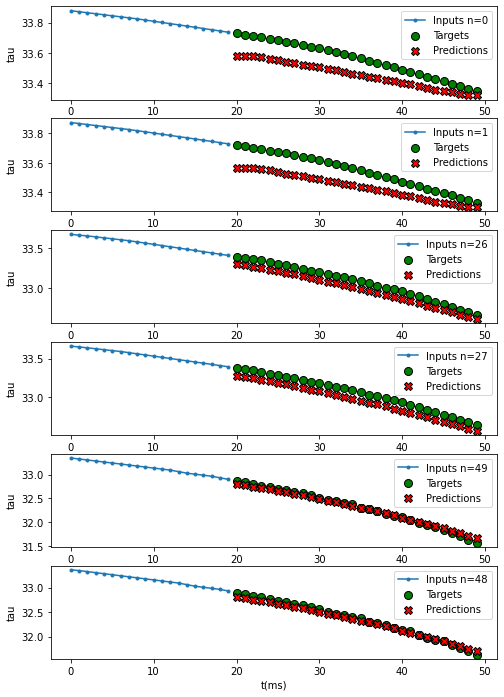

In [26]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in mul_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
mul_window.plot(nor_inputs,nor_labels,batch_size, model=mul_dense,plot_col='tau')

Inputs shape (batch, time, features): (50, 20, 16)
Labels shape (batch, time, features): (50, 30, 1)
Inputs shape (batch, time, features): (50, 20, 16)
Labels shape (batch, time, features): (50, 30, 1)
Inputs shape (batch, time, features): (21, 20, 16)
Labels shape (batch, time, features): (21, 30, 1)
0:00:03.178892


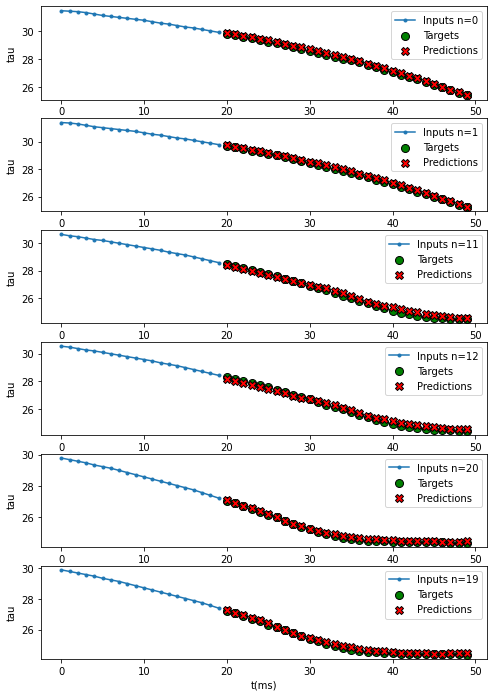

In [27]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in mul_window_test.take(3):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
mul_window.plot(nor_inputs,nor_labels,batch_size, model=mul_dense,plot_col='tau')

Inputs shape (batch, time, features): (50, 20, 16)
Labels shape (batch, time, features): (50, 30, 1)
Inputs shape (batch, time, features): (50, 20, 16)
Labels shape (batch, time, features): (50, 30, 1)
Inputs shape (batch, time, features): (21, 20, 16)
Labels shape (batch, time, features): (21, 30, 1)
Inputs shape (batch, time, features): (50, 20, 16)
Labels shape (batch, time, features): (50, 30, 1)
0:00:03.138281


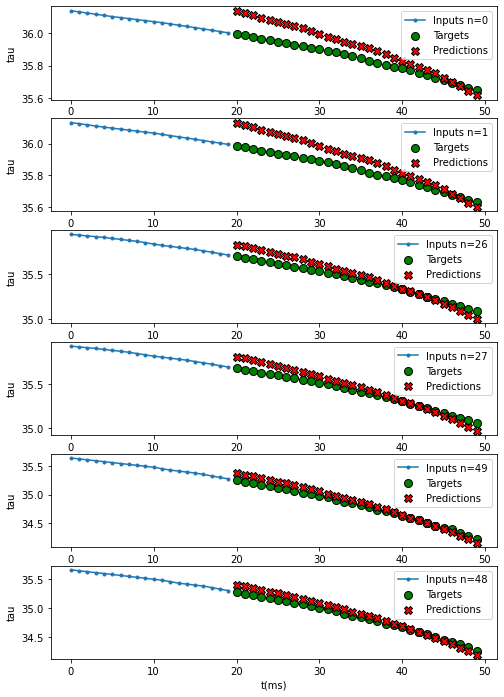

In [28]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in mul_window_test.take(4):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
mul_window.plot(nor_inputs,nor_labels,batch_size, model=mul_dense,plot_col='tau')

Inputs shape (batch, time, features): (10, 25, 16)
Labels shape (batch, time, features): (10, 25, 1)
0:00:01.023346


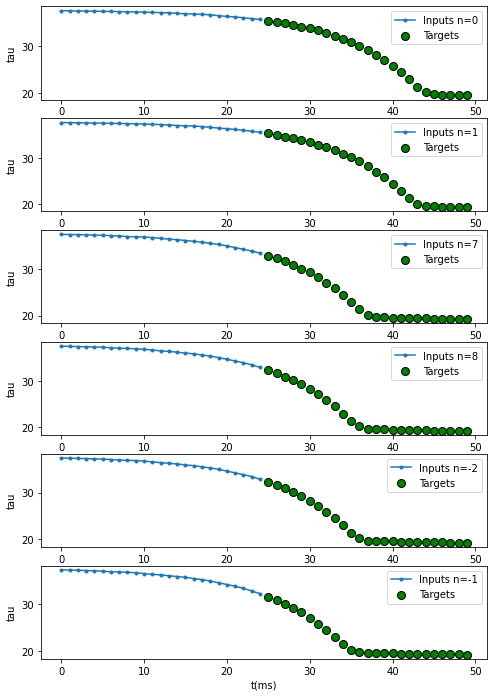

In [25]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
multi_window.plot(nor_inputs,nor_labels,batch_size, plot_col='tau')

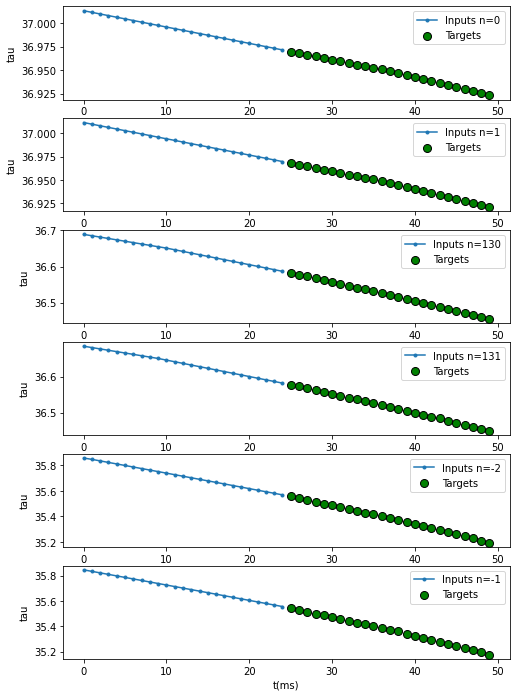

In [14]:
# multi_window_test.take(1) --> The first batch of the first group of test_df
multi_window.plot(nor_inputs,nor_labels,batch_size, plot_col='tau')

Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
Inputs shape (batch, time, features): (4, 25, 16)
Labels shape (batch, time, features): (4, 25, 1)
0:00:15.112886


2022-09-19 12:05:11.163489: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:102 : INVALID_ARGUMENT: slice index 27 of dimension 0 out of bounds.


InvalidArgumentError: slice index 27 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

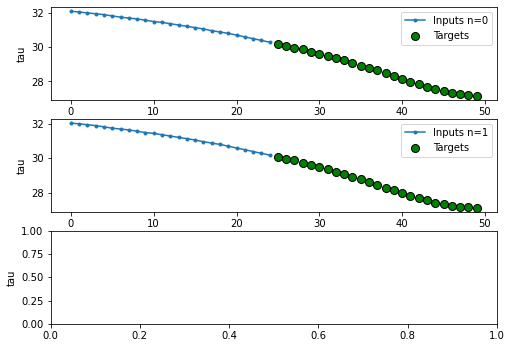

In [16]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(2):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# For batch_size=256 multi_window_test.take(2) --> At middle and end
multi_window.plot(nor_inputs,nor_labels,batch_size, plot_col='tau')

898.0
(62, 16)


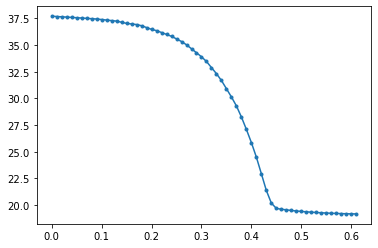

In [32]:
#test_df
df_grouptest=df[df['group_id']==test_df.group_id.unique()[0]]
plt.plot(df_grouptest.index*1e-2, df_grouptest.tau, marker='.')
print(test_df.group_id.unique()[0])
print(df_grouptest.shape)

In [42]:
#Create Baseline
def abl_tau(df):
    labels=pd.DataFrame()
    labels[['a','b','L']]=df.groupby('group_id').apply(lambda x: x.iloc[0,1:4])
    targets=pd.DataFrame()
    targets['tau_min']=df.groupby('group_id').apply(lambda x: x.min()['tau'])
    targets['tau_max']=df.groupby('group_id').apply(lambda x: x.max()['tau'])
    return labels, targets

abl, tau=abl_tau(df)
abl_train, abl_test, tau_train, tau_test = train_test_split(abl, tau, test_size=0.1)

tau_model=LinearRegression()
tau_model.fit(abl_train, tau_train)
tau_model_score=tau_model.score(abl_test, tau_test)
tau_pred=tau_model.predict(abl_test)
tau_model_loss=mean_squared_error(tau_test, tau_pred)
print(f'tau_Linear_mse: {tau_model_loss}')
print(f'tau_Linear_accuracy: {tau_model_score}')

tau_Linear_mse: 0.002377150109059091
tau_Linear_accuracy: 0.9996214059945616
[1.0000e+00 2.0000e+00 3.0000e+00 ... 2.1135e+04 2.1136e+04 2.1137e+04]


In [43]:
def normalization(data,train_mean=train_mean, train_std=train_std):
    norm_tau=(data-train_mean.tau)/train_std.tau
    return norm_tau
groups=train_df.group_id.unique()
Baseline_loss=np.empty(len(groups))
nor_baseline_loss=np.empty(len(groups))
labels=[]
for i in range(len(groups)):
    i=groups[i]
    abl=train_df[train_df['group_id']==i].iloc[0,1:4].to_list()
    labels.append(abl)
print(np.shape(labels))
tau=np.empty((len(groups),2))
tau=tau_model.predict(labels) #[taumin,taumax]
print(pred_tau)
for i in range(len(groups)):
    j=groups[i]
    t_end=len(train_df[train_df['group_id']==j])
    t=train_df[train_df['group_id']==j].index.to_numpy()
    true_tau=train_df[train_df['group_id']==j].iloc[:,-1].to_numpy()
    baseline_tau=np.arange(0,t_end,1)
    for n in range(t_end):
        baseline_tau[n]=(t[n]-t_end)*(tau[i,-1]-tau[i,0])/(-t_end)+tau[i,0]
    Baseline_loss[i]=((true_tau-baseline_tau)**2).mean(axis=None)
    nor_baseline_loss[i]=((normalization(true_tau)-normalization(baseline_tau))**2).mean(axis=None)
loss=np.mean(Baseline_loss)
nor_loss=np.mean(nor_baseline_loss)
print(f'Baseline_mse_loss: {loss}') #Baseline_mse_loss: 10.260404800864343
print(f'Normalization_Baseline_mse_loss: {nor_loss}') #Normalization_Baseline_mse_loss: 0.5182625849957053

(16384, 3)
[[27.1182066  32.45834378]
 [26.91726101 32.37148064]
 [28.15212632 32.90527827]
 ...
 [18.41052335 36.10984737]
 [18.75828463 36.26017482]
 [23.7147681  38.40272359]]
Baseline_mse_loss: 10.260404800864343
Normalization_Baseline_mse_loss: 0.5182625849957053


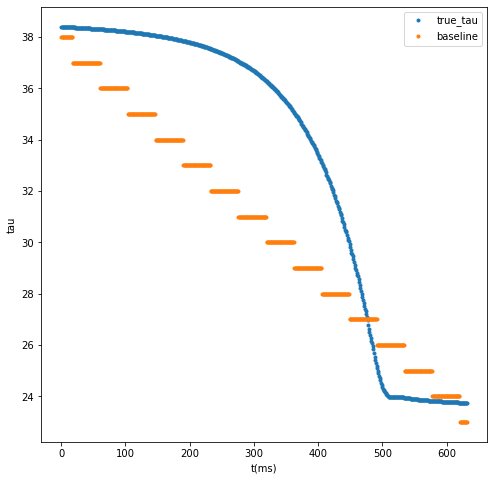

In [44]:
plt.figure(figsize=(8,8))
plt.xlabel('t(ms)')
plt.ylabel('tau')
plt.plot(t,true_tau, '.',label='true_tau')
plt.plot(t,baseline_tau, '.',label='baseline')
plt.legend()

In [80]:
def compile_and_fit(model,max_epochs, window_train,window_val,window_test, patience=10):
    early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=patience,
                                                  mode='min')
    model.compile(loss=MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[MeanAbsoluteError()])
    history=model.fit(window_train, epochs=max_epochs,
                    validation_data=window_val,
                    callbacks=[early_stopping])
    return history

# Build model
# Dense
def multi_dense_model(out_step, num_features):
    model=Sequential(
        [#Shape [batch, point, features] --> [batch, 1, features] take the last point
         layers.Lambda(lambda x: x[:,-1:,:]),
         layers.Dense(units=256, activation='relu'),
         layers.Dense(units=128, activation='relu'),
         layers.Dense(units=out_step*num_features,
                      kernel_initializer=tf.initializers.zeros()),
         layers.Reshape([out_step, num_features])])
    return model

In [28]:
# Training process, give epochs(combined with batch_size)
max_epochs=10
#for tau prediction, the num_features is 1
multi_dense=multi_dense_model(out_step, 1)
print('Multi Dense')
history=compile_and_fit(multi_dense, max_epochs, multi_window_train, multi_window_val, multi_window_test)
print(multi_dense.summary())
val_performance={}
performance={}
val_performance['Multi_Dense']=multi_dense.evaluate(multi_window_test)
performance['Multi_Dense']=multi_dense.evaluate(multi_window_test)

Multi Dense
Epoch 1/10
1945/1945 [==============================] - 17s 8ms/step - loss: 0.0271 - mean_absolute_error: 0.0879 - val_loss: 0.0713 - val_mean_absolute_error: 0.1626
Epoch 2/10
1945/1945 [==============================] - 12s 6ms/step - loss: 0.0084 - mean_absolute_error: 0.0511 - val_loss: 0.0195 - val_mean_absolute_error: 0.0928
Epoch 3/10
1945/1945 [==============================] - 12s 6ms/step - loss: 0.0046 - mean_absolute_error: 0.0411 - val_loss: 0.0256 - val_mean_absolute_error: 0.1046
Epoch 4/10
1945/1945 [==============================] - 12s 6ms/step - loss: 0.0037 - mean_absolute_error: 0.0357 - val_loss: 0.0112 - val_mean_absolute_error: 0.0715
Epoch 5/10
1945/1945 [==============================] - 12s 6ms/step - loss: 0.0030 - mean_absolute_error: 0.0325 - val_loss: 0.0093 - val_mean_absolute_error: 0.0667
Epoch 6/10
1945/1945 [==============================] - 13s 6ms/step - loss: 0.0028 - mean_absolute_error: 0.0327 - val_loss: 0.0157 - val_mean_absolute_

Inputs shape (batch, time, features): (10, 25, 16)
Labels shape (batch, time, features): (10, 25, 1)
0:00:01.283369


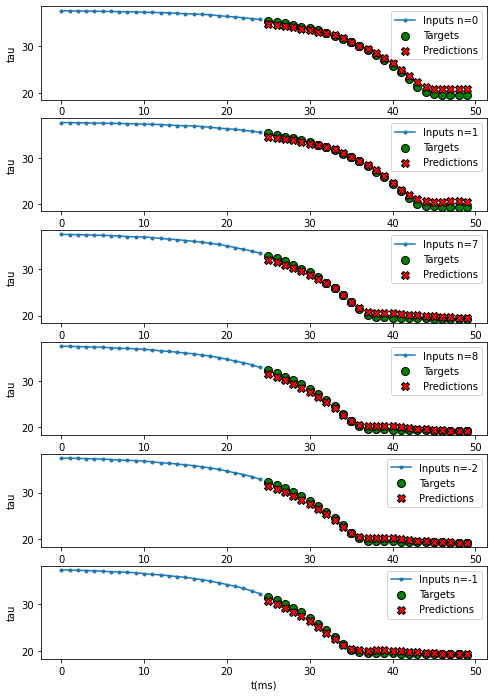

In [29]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
multi_window.plot(nor_inputs,nor_labels,batch_size, model=multi_dense, plot_col='tau')

Inputs shape (batch, time, features): (10, 25, 16)
Labels shape (batch, time, features): (10, 25, 1)
Inputs shape (batch, time, features): (3, 25, 16)
Labels shape (batch, time, features): (3, 25, 1)
Inputs shape (batch, time, features): (10, 25, 16)
Labels shape (batch, time, features): (10, 25, 1)
0:00:01.278775


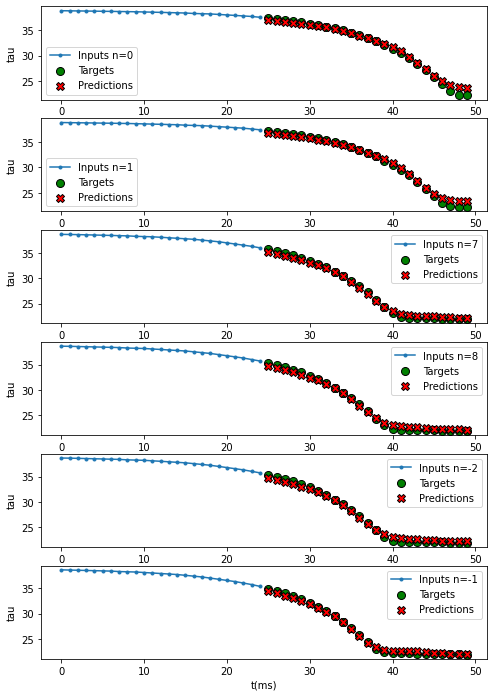

In [30]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(3):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
multi_window.plot(nor_inputs,nor_labels,batch_size, model=multi_dense, plot_col='tau')

In [36]:
df,N=Datasample(total_df1).add_features(Nt)
print(df.shape)
num_columns=df.shape[-1]
column_indices={name: i for i, name in enumerate(df.columns)}
print(num_columns)
print(column_indices)

train_df, val_df, test_df, N_new=Datasample(df).split_df(N)
print(f'train_df.shape={train_df.shape}')
print(f'val_df.shape={val_df.shape}')
print(f'test_df.shape={test_df.shape}')

train_df_nor, val_df_nor, test_df_nor, train_mean, train_std=Datasample(df).normalization(train_df, val_df, test_df)
print(f'train_df_nor.shape = {train_df_nor.shape}')
print(f'val_df_nor.shape = {val_df_nor.shape}')
print(f'test_df_nor.shape = {test_df_nor.shape}')
print(f'train_mean = {train_mean}')
print(f'train_std = {train_std}')

0:00:10.084385
(134578, 16)
16
{'group_id': 0, 'a': 1, 'b': 2, 'L': 3, 'dtau': 4, 'dtau2': 5, 'theta': 6, 'dtheta': 7, 'dtheta2': 8, 'U': 9, 'dU': 10, 'dU2': 11, 'V': 12, 'dV': 13, 'dV2': 14, 'tau': 15}
train_df.shape=(93577, 16)
val_df.shape=(25871, 16)
test_df.shape=(15130, 16)
train_df_nor.shape = (93577, 16)
val_df_nor.shape = (25871, 16)
test_df_nor.shape = (15130, 16)
train_mean = group_id       345.830963
a                0.005797
b                0.012639
L                0.024866
dtau             0.077815
dtau2            0.155548
theta       614157.282310
dtheta       20527.689733
dtheta2      40704.364222
U                0.242864
dU              -0.004477
dU2             -0.008883
V                0.899450
dV              -0.016024
dV2             -0.016024
tau             32.163738
dtype: float64
train_std = group_id    1.985938e+02
a           2.681886e-03
b           4.210118e-03
L           1.000000e+00
dtau        1.217448e-01
dtau2       2.423847e-01
theta       1.611

In [37]:
train_groups=train_df.group_id.unique()
val_groups=val_df.group_id.unique()
test_groups=test_df.group_id.unique()
print(len(train_groups))
print(len(val_groups))
print(len(test_groups))

625
178
89


In [38]:
# Generate multi_window: multiple steps output
batch_size=50
out_step=25
multi_window=WindowGenerator(input_width=25, label_width=out_step, shift=out_step,
                             train_df=train_df_nor, val_df=val_df_nor, test_df=test_df_nor,
                             label_columns=['tau'])
print(multi_window)

multi_window_train=multi_window.make_dataset(train_df_nor, batch_size, is_training=True)
multi_window_val=multi_window.make_dataset(val_df_nor, batch_size, is_training=True)
multi_window_test=multi_window.make_dataset(test_df_nor, batch_size, is_training=False)
num_features=train_df_nor.shape[-1]
print(num_features)

Total window size: 50
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49]
Label column name(s): ['tau']
0:00:13.628992
0:00:04.962881
0:00:01.846020
16


Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
0:00:01.593842


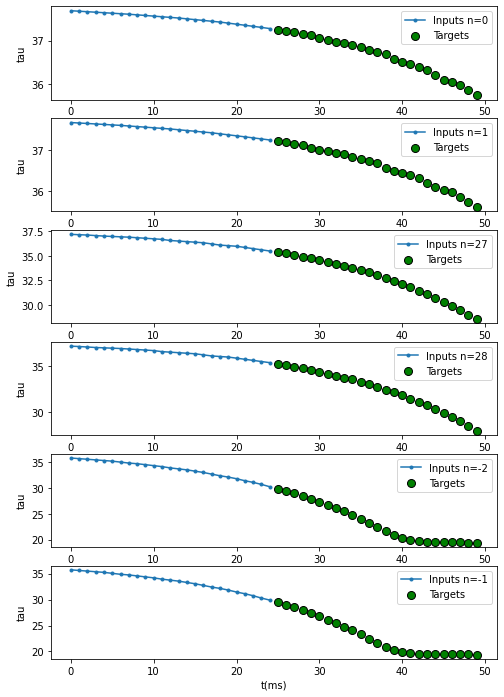

In [39]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
multi_window.plot(nor_inputs,nor_labels,batch_size, plot_col='tau')

898.0
(123, 16)


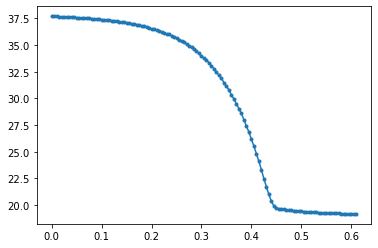

In [48]:
#test_df
df_grouptest=df[df['group_id']==test_df.group_id.unique()[0]]
plt.plot(df_grouptest.index*5e-3, df_grouptest.tau, marker='.')
print(test_df.group_id.unique()[0])
print(df_grouptest.shape)

In [54]:
# Training process, give epochs(combined with batch_size)
max_epochs=30
#for tau prediction, the num_features is 1
multi_dense=multi_dense_model(out_step, 1)
print('Multi Dense')
history=compile_and_fit(multi_dense, max_epochs, multi_window_train, multi_window_val, multi_window_test)
print(multi_dense.summary())
val_performance['Multi_Dense_5ms']=multi_dense.evaluate(multi_window_test)
performance['Multi_Dense_5ms']=multi_dense.evaluate(multi_window_test)

Multi Dense
Epoch 1/30
1525/1525 [==============================] - 15s 10ms/step - loss: 0.0145 - mean_absolute_error: 0.0597 - val_loss: 0.0212 - val_mean_absolute_error: 0.1066
Epoch 2/30
1525/1525 [==============================] - 16s 10ms/step - loss: 0.0028 - mean_absolute_error: 0.0306 - val_loss: 0.0084 - val_mean_absolute_error: 0.0675
Epoch 3/30
1525/1525 [==============================] - 16s 10ms/step - loss: 0.0029 - mean_absolute_error: 0.0269 - val_loss: 0.0074 - val_mean_absolute_error: 0.0648
Epoch 4/30
1525/1525 [==============================] - 15s 10ms/step - loss: 0.0014 - mean_absolute_error: 0.0225 - val_loss: 0.0067 - val_mean_absolute_error: 0.0622
Epoch 5/30
1525/1525 [==============================] - 15s 10ms/step - loss: 0.0020 - mean_absolute_error: 0.0244 - val_loss: 0.0046 - val_mean_absolute_error: 0.0515
Epoch 6/30
1525/1525 [==============================] - 15s 10ms/step - loss: 9.8739e-04 - mean_absolute_error: 0.0189 - val_loss: 0.0039 - val_mean

Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
0:00:01.516120


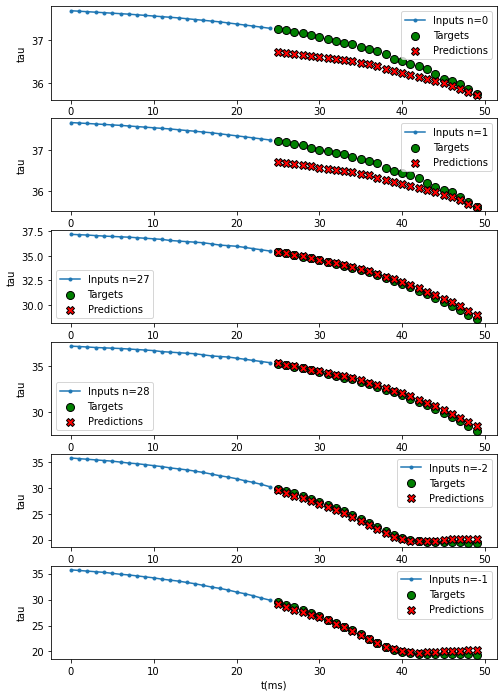

In [55]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(1):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
multi_window.plot(nor_inputs,nor_labels,batch_size, model=multi_dense, plot_col='tau')

Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
Inputs shape (batch, time, features): (24, 25, 16)
Labels shape (batch, time, features): (24, 25, 1)
Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
Inputs shape (batch, time, features): (28, 25, 16)
Labels shape (batch, time, features): (28, 25, 1)
Inputs shape (batch, time, features): (50, 25, 16)
Labels shape (batch, time, features): (50, 25, 1)
Inputs shape (batch, time, features): (33, 25, 16)
Labels shape (batch, time, features): (33, 25, 1)
0:00:01.667237


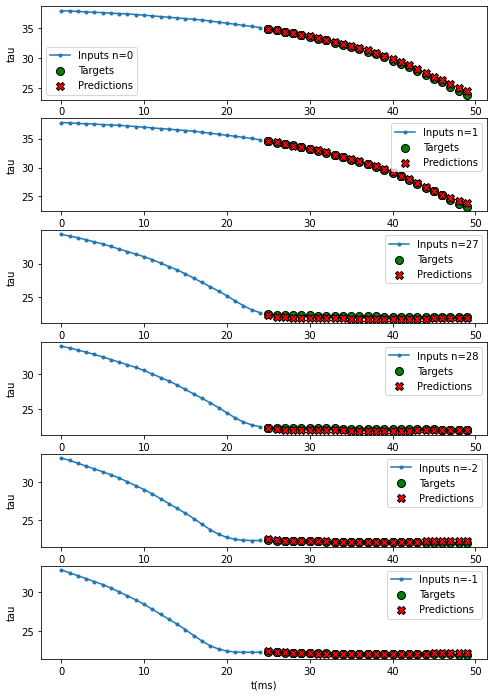

In [56]:
start_datetime=datetime.now()
for nor_inputs, nor_labels in multi_window_test.take(6):
    print(f'Inputs shape (batch, time, features): {nor_inputs.shape}')
    print(f'Labels shape (batch, time, features): {nor_labels.shape}')
print(datetime.now()-start_datetime)
# multi_window_test.take(1) --> The first batch of the first group of test_df
multi_window.plot(nor_inputs,nor_labels,batch_size, model=multi_dense, plot_col='tau')

In [ ]:
# Conv
def multi_conv_model(out_step, num_features, multi_conv_width):
    model=Sequential(
      [layers.Lambda(lambda x: x[:,-multi_conv_width:,:]),
       layers.Conv1D(filters=256, kernel_size=(multi_conv_width,), activation='relu'),
       layers.Dense(units=out_step*num_features,
                    kernel_initializer=tf.initializers.zeros()),
       layers.Reshape([out_step, num_features])])
    return model
multi_conv_width=25
multi_conv=multi_conv_model(out_step, 1, multi_conv_width)
print('Multi Conv')
history=compile_and_fit(multi_conv, max_epochs, multi_window_train, multi_window_val, multi_window_test)
print(multi_conv.summary())
#multi_window.plot(batch_size,N, plot_col=['tau'],model=multi_conv)
val_performance['Multi_Conv']=multi_conv.evaluate(multi_window_test)
performance['Multi_Conv']=multi_conv.evaluate(multi_window_test)
#Conv is better than Dense